# Readme:

In this Notebook, we show how to:
* Calculate the nominal returns and the real returns after adjusting for inflation in a reference currency:
    - There are fetching functions allowing users to retrieve data from yahoo finance: historical prices and dividends, historical FX rate and from FRED: inflation data.
    - The calculation proceeds as follows:
        - We choose the reference currency,
        - We calculate the periodic (weekly, monthly, quarterly, annually) nominal relative returns tobe the change in prices during the period.
        - We also calculat the relative inflation rate as the change in the CPI during the period.
        - We can then adjust the nominal relative returns to inflation.
        - The cumulative nominal return over a period of time is the cumulative product of (1+r_i) minus 1.
        - In order to adjust the cuulative nominal return for infation, we calculate the cumulative inflation factor.
        
    - Different returns were calculated for different instruments, cash included. The goal was to show the impact of infation on returns.
    - Moreover, different instruments were compared based on their returns, see below the type of instruments used in the calculation.
    

* implement the mean-variance approach in order to choose the optimal portfolio allocation among a fixed set of assets.
    - The code can handle assets that have availale tickers on yahoo.
    - The assets can be quoted in different currencies (for instance USD, GBp, CHF,)
    - The assets universe is chosen to be ETFs: market index ETFs tracking the performance of major economies (S&P500, FTSE100, SMI,...), commodities ETFs (phyical gold ETF trust tracking the performance of the gold commodity) and Bitcoin (Bitcoin is a cryptocurrency)
    - Index ETFs are Equity ETFs and they pay dividends. Gold and Bitcoin do not pay dividends.
    - The code can handle assets paying dividends.
    - The base currency is assumed to be USD. The user is free to change the base currency to any currency for which there is FX rate data available.
    - It is assumed here that dividends received are systematically reinvested in purchasing more of the security.
    - Nominal monthly returns are calculated after converting all the prices and dividends to  the reference currency.
    - Annualised volatilities are then calculated, then covariance and correlation matrices.
    - The optimal portfolio using the mean var approach relies on the following assumptions (recall the assumptions). One can formulate the optimization problem in the following way: maximise the returns under volatility constraint (volatility does not exceed a certain threshold), or minimise the variance under returns constraint (minimum return threshold)
    - We call minimise from scipy which uses these routines (which routines) to find the optimal weights.
    - We plot the efficient frontier and we simulate for different weights to visualise the risk returns tradeoff, as well as the risk adjusted returns (Sharpe ratio).
    
* implement a buy and hold strategy backtester with different instruments:
    - For illustration purposes, we make an asset allocation according to the weights obtained by the mean-var approach.
    - We asume that dividends are reinvested and that there are no transaction cost.
    - The buy and hold strategy is implemented as Class:
        - It is initialised using the historical nominal returns, the initial weights, interest rate (for Sharpe calculation), the initial investment.
        - It calculates the portfolio relative periodic returns, the cumulative returns and the growth rate of the portfolio.
        - It calculates final portfolio value, Sharpe ratio.
        - It plots the outcomes
        
        
* implement a dollar cost averaging strategy with different instruments:
    - Here, we assume that the user contributes periodically (monthly as we chose monthly returns for this case) to the portfolio which was initialised using the mean var approach.
    - We also assume that contributions will be allocated equally among the assets regardless of their weights.
    - We also assume that there are no transaction costs, that the amount of contributions is fixed and occurs at the end of every period.
    - Calculating returns can be tricky:
        - Of course, we can calculate the returns as in the buy and hold strategy, but the returns take into considerations the contributions. The latter distort the returns.
        - Contributions should be tackled as capital at risk and they are supposed to decrease the returns on the portfolio.
        - The returns must be adjusted according to the formula...
        - Time weighted returns are calculated instead of the traditional relative returns
        - Also, in order to evaluate the performance of the portfolio as an investment, we calculated the internal rate of return, but results depend on the optimisation algorithms. Detailed analysis needs to be conducted.
        - The irr solver contains a test case then it is applied to the portfolio.
        
    

# Next steps:


*   Change the base currency and see how returns are affected
*   Study the correlations between the indices
*   Scale some cells: transform them into modules: periodic return calculation from daily returns
*   Calculate the inflation adjusted returns for each strategy
*   Calculate the evolution of the portfolio weights within the class
*   





In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
from datetime import date, timedelta
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import minimize

# Introduction:

In this Notebook, we are going to assess the real returns on an index buy and hold strategy over a past period if time.

The index that we choose is the S&P500.

What are the input data that I needed to run the backtest for each security?



*   The ticker of the security
*   The backtesting window
*   The inflation ticker




# Nominal returns vs Real (Inflation Adjusted) returns

In [7]:
def fetch_inflation_data(inflation_curve, start_date, end_date):
    # Fetch data from FRED (Federal Reserve Economic Data)
    url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id=' + inflation_curve
    CPI_data = pd.read_csv(url, index_col=0, parse_dates=True)
    CPI_data = CPI_data.loc[start_date:end_date]
    CPI_data = CPI_data.reset_index()
    inflation_df = CPI_data.copy()
    inflation_df = inflation_df.reset_index(drop=True)

    return inflation_df


# Function to fetch historical data for a given ticker symbol within a specified date range
def fetch_historical_data(ticker, start_date, end_date):
    # Download historical data using yfinance
    data = yf.download(ticker, start=start_date, end=end_date, actions=True)

    # Create a DataFrame with the date and adjusted closing prices
    prices_df = pd.DataFrame({'Date': data.index, 'Price': data['Adj Close']})

    # Reset the index of the DataFrame
    prices_df = prices_df.reset_index(drop=True)
    # Uncomment the line below to print the first few rows of the prices DataFrame for debugging
    # print(prices_df.head())
    return prices_df

# Function to fetch historical dividend data for a given ticker symbol within a specified date range
def fetch_historical_dividends(ticker, start_date, end_date):
    # Download historical data using yfinance
    data = yf.download(ticker, start=start_date, end=end_date, actions=True)

    # Filter the data to get only the rows where dividends are greater than 0
    dividends = data[data['Dividends'] > 0]

    # Create a DataFrame with the date and dividend amounts
    dividends_df = pd.DataFrame({'Date': dividends.index, 'Dividend': dividends['Dividends']})

    # Reset the index of the dividends DataFrame
    df_dividends = dividends_df.reset_index(drop=True)
    # Check if the dividends DataFrame is empty and print a message if so
    if dividends.empty:
        print("No dividends found for the selected period.")
    return df_dividends

# Function to fetch foreign exchange (FX) data for a given FX ticker within a specified date range
def fetch_FX_data(FX_ticker, start_date, end_date):
    # Download FX data using yfinance
    FX_data = yf.download(FX_ticker, start=start_date, end=end_date, actions=True)

    # Create a DataFrame with the date and FX rates
    FX_df = pd.DataFrame({'Date': FX_data.index, 'FX_rate': FX_data['Adj Close']})

    # Reset the index of the FX DataFrame
    FX_df = FX_df.reset_index(drop=True)
    return FX_df

# Function to merge price and dividend data for a given ticker within a specified date range
def merge_price_dividends(ticker, start_date, end_date):
    # Fetch historical price data
    price_data = fetch_historical_data(ticker, start_date, end_date)
    # Fetch historical dividend data
    dividends_data = fetch_historical_dividends(ticker, start_date, end_date)

    # If no dividends data is found, create an empty DataFrame with the appropriate columns
    if dividends_data is None:
        dividends_data = pd.DataFrame(columns=['Date', 'Dividend'])

    # Merge prices and dividends dataframes on date
    merged_df = pd.merge(price_data, dividends_data, on='Date', how='left')

    # Fill missing dividends with 0, since not every day will have a dividend
    merged_df['Dividend'] = merged_df['Dividend'].fillna(0)

In [8]:
def get_price_and_dividend_currency(ticker):
    # Fetch the ticker data
    stock = yf.Ticker(ticker)

    # Retrieve the stock's currency (for the price)
    price_currency = stock.info.get('currency', 'Currency not available')

    # Download the historical dividends
    dividends = stock.dividends

    # If dividends exist, fetch the currency from the 'Dividends' field
    if not dividends.empty:
        div_currency = stock.info.get('dividendCurrency', price_currency)  # Sometimes dividendCurrency is not available
    else:
        div_currency = "No dividends available"

    return price_currency, div_currency

# Example usage
ticker = 'ISF.L'  # FTSE100 ETF
price_currency, div_currency = get_price_and_dividend_currency(ticker)

print(f"Price Currency: {price_currency}")
print(f"Dividend Currency: {div_currency}")


Price Currency: GBp
Dividend Currency: GBp


In [9]:
# Set the inputs:
# - Define the size of the backtesting window in years
Size = 18 # The size of the backtesting window in years

# Calculate the end date for the backtesting period, avoiding the last day to prevent API issues
end_date = date.today() - timedelta(days=7) # Try to avoid the last day because of possible API issues

# Calculate the start date by subtracting the backtesting window size from the end date
start_date = end_date.replace(year=end_date.year - Size)

# Define the base currency for the financial data
base_currency = 'USD'

# Print the calculated start and end dates for verification
print("Start date: ", start_date)
print("End date: ", end_date)

# Define the inflation curve to be used in the analysis
inflation_curve = 'CPIAUCSL'

# List of tickers for the assets to be analyzed
Tickers = ['SPY', 'CSSMI.SW', 'ISF.L', 'IAU', 'BTC-USD'] # 'SPY' corresponds to the S&P500 distributing index ETF and 'IAU' corresponds to the Index Physical Gold Trust ETF. Both quotes in the USD. The third ticker stands for Bitcoin.

# List of foreign exchange tickers for currency analysis
FX_Tickers = ['CHFUSD=X', 'GBPUSD=X']

Start date:  2006-09-30
End date:  2024-09-30


In [10]:
# Initialize dictionaries to store price data, dividend data, and foreign exchange (FX) data for each ticker
prices_dfs = {}
dividends_dfs = {}
FX_dfs = {}

# Loop through each ticker in the list of Tickers to fetch historical price and dividend data
for ticker in Tickers:
    print()  # Print a new line for better readability in the output
    print(f"Fetching data for {ticker}...\n")  # Indicate which ticker's data is being fetched
    # Fetch historical price data for the current ticker and store it in the prices_dfs dictionary
    prices_dfs[ticker] = fetch_historical_data(ticker, start_date, end_date)
    # Fetch historical dividend data for the current ticker and store it in the dividends_dfs dictionary
    dividends_dfs[ticker] = fetch_historical_dividends(ticker, start_date, end_date)

# Loop through each ticker in the list of FX_Tickers to fetch foreign exchange data
for ticker in FX_Tickers:
    print()  # Print a new line for better readability in the output
    print(f"Fetching data for {ticker}...\n")  # Indicate which FX ticker's data is being fetched
    # Fetch foreign exchange data for the current FX ticker and store it in the FX_dfs dictionary
    FX_dfs[ticker] = fetch_FX_data(ticker, start_date, end_date)

# Fetch inflation data based on the specified inflation curve and date range
inflation_df = fetch_inflation_data(inflation_curve, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


Fetching data for SPY...




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Fetching data for CSSMI.SW...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Fetching data for ISF.L...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Fetching data for IAU...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


No dividends found for the selected period.

Fetching data for BTC-USD...

No dividends found for the selected period.

Fetching data for CHFUSD=X...


Fetching data for GBPUSD=X...



[*********************100%***********************]  1 of 1 completed


In [11]:
# Printing the first rows of the dfs

for ticker, prices_df in prices_dfs.items():
    print(f"Prices for {ticker}:")
    print(prices_df.head())

for ticker, dividends_df in dividends_dfs.items():
    print(f"Dividends for {ticker}:")
    print(dividends_df.head())
for ticker, FX_df in FX_dfs.items():
    print(f"FX for {ticker}:")
    print(FX_df.head())

print("CPI :\n")
print(inflation_df.head())

Prices for SPY:
        Date      Price
0 2006-10-02  94.457451
1 2006-10-03  94.656197
2 2006-10-04  95.763451
3 2006-10-05  95.947983
4 2006-10-06  95.827301
Prices for CSSMI.SW:
        Date      Price
0 2008-01-03  59.979439
1 2008-01-04  58.616699
2 2008-01-07  58.474567
3 2008-01-08  59.958580
4 2008-01-09  60.126743
Prices for ISF.L:
        Date       Price
0 2009-01-02  456.429352
1 2009-01-05  458.171417
2 2009-01-06  463.397797
3 2009-01-07  449.460968
4 2009-01-08  450.207733
Prices for IAU:
        Date   Price
0 2006-10-02  11.820
1 2006-10-03  11.430
2 2006-10-04  11.274
3 2006-10-05  11.392
4 2006-10-06  11.370
Prices for BTC-USD:
        Date       Price
0 2014-09-17  457.334015
1 2014-09-18  424.440002
2 2014-09-19  394.795990
3 2014-09-20  408.903992
4 2014-09-21  398.821014
Dividends for SPY:
        Date  Dividend
0 2006-12-15     0.793
1 2007-03-16     0.551
2 2007-06-15     0.656
3 2007-09-21     0.719
4 2007-12-21     0.775
Dividends for CSSMI.SW:
        Date  

In [12]:

def transform_price_currency(df, FX_df, base_currency, target_currency):
  """Transforms the price from one currency to another if different from base currency.

  Args:
    df: DataFrame containing the price data.
    FX_df: DataFrame containing the FX data for the currency transformation.
    base_currency: The original currency of the price.
    target_currency: The target currency to convert the price to.

  Returns:
    DataFrame with transformed prices if necessary, original prices otherwise.
  """

  if base_currency == target_currency:
    return df  # No transformation needed
  else:
    # Merge price and FX data on date
    merged_df = pd.merge(df, FX_df, on='Date', how='left')

    if 'Price' in df.columns:
      if target_currency == 'GBp':
        # Perform currency conversion if FX rate is available

        merged_df['Transformed Price'] = merged_df['Price'] * merged_df['FX_rate']

        merged_df['Transformed Price'] = merged_df['Transformed Price'] * 0.01

        transformed_prices_df = merged_df[['Date', 'Price', 'Transformed Price']].copy()
      else:
        # Perform currency conversion if FX rate is available
        merged_df['Transformed Price'] = merged_df['Price'] * merged_df['FX_rate']
        transformed_prices_df = merged_df[['Date', 'Price', 'Transformed Price']].copy()
    elif 'Dividend' in df.columns:
      if target_currency == 'GBp':
        # Perform currency conversion if FX rate is available
        merged_df['Transformed Dividend'] = 0.01* merged_df['Dividend'] * merged_df['FX_rate']
      else:
        # Perform currency conversion if FX rate is available
        merged_df['Transformed Dividend'] = merged_df['Dividend'] * merged_df['FX_rate']

      # Return only the transformed price, date, and keep the original price
      transformed_prices_df = merged_df[['Date', 'Dividend', 'Transformed Dividend']].copy()
    return transformed_prices_df




In [13]:
transformed_prices_dfs = {}
transformed_dividends_dfs = {}
for ticker in Tickers:
  price_currency, div_currency = get_price_and_dividend_currency(ticker)
  if price_currency != base_currency:
    if price_currency == 'GBp':
      price_currency_bis = 'GBP'
      transformed_prices_dfs[ticker] = transform_price_currency(prices_dfs[ticker], FX_dfs[f'{price_currency_bis}{base_currency}=X'], base_currency, price_currency)
      transformed_dividends_dfs[ticker] = transform_price_currency(dividends_dfs[ticker], FX_dfs[f'{price_currency_bis}{base_currency}=X'], base_currency, price_currency)
    else:
      transformed_prices_dfs[ticker] = transform_price_currency(prices_dfs[ticker], FX_dfs[f'{price_currency}{base_currency}=X'], base_currency, price_currency)
      transformed_dividends_dfs[ticker] = transform_price_currency(dividends_dfs[ticker], FX_dfs[f'{price_currency}{base_currency}=X'], base_currency, price_currency)
  else:
    if price_currency == 'GBp':
      price_currency = 'GBP'
    transformed_prices_dfs[ticker] = prices_dfs[ticker]
    transformed_dividends_dfs[ticker] = dividends_dfs[ticker]


for ticker, prices_df in transformed_prices_dfs.items():
    print(f"Prices for {ticker}:")
    print(prices_df.head())

Prices for SPY:
        Date      Price
0 2006-10-02  94.457451
1 2006-10-03  94.656197
2 2006-10-04  95.763451
3 2006-10-05  95.947983
4 2006-10-06  95.827301
Prices for CSSMI.SW:
        Date      Price  Transformed Price
0 2008-01-03  59.979439          53.962606
1 2008-01-04  58.616699          52.946165
2 2008-01-07  58.474567          52.312190
3 2008-01-08  59.958580          53.909889
4 2008-01-09  60.126743          53.867356
Prices for ISF.L:
        Date       Price  Transformed Price
0 2009-01-02  456.429352           6.629137
1 2009-01-05  458.171417           6.742475
2 2009-01-06  463.397797           6.910197
3 2009-01-07  449.460968           6.777463
4 2009-01-08  450.207733           6.855294
Prices for IAU:
        Date   Price
0 2006-10-02  11.820
1 2006-10-03  11.430
2 2006-10-04  11.274
3 2006-10-05  11.392
4 2006-10-06  11.370
Prices for BTC-USD:
        Date       Price
0 2014-09-17  457.334015
1 2014-09-18  424.440002
2 2014-09-19  394.795990
3 2014-09-20  408

* The code below can be transformed to a module. Returns do not have to be calculated on a monthly basis but on any period. The function has the following inputs: prices data, dividends data, resampling frequency.
* The returns data is the backbone for the remaining of the analysis.

In [14]:
# Create a DataFrame to store total returns with a 'Date' column and one column for each ticker
Total_Returns_df = pd.DataFrame(columns =['Date'] + [f'{ticker}' for ticker in Tickers])
Total_Returns_df.head()

# Create a DataFrame to store monthly returns with one column for each ticker
monthly_returns = pd.DataFrame(columns =[f'{ticker}' for ticker in Tickers])
monthly_returns.head()

# Loop through each ticker to calculate total and monthly returns
for ticker in Tickers:
    # Retrieve the price and dividend DataFrames for the current ticker
    prices_df = prices_dfs[ticker]
    dividends_df = dividends_dfs[ticker]

    # Merge the price and dividend DataFrames on the 'Date' column
    merged_df = pd.merge(prices_df, dividends_df, on='Date', how='left')

    # If 'Transformed Price' exists, use it to update the 'Price' column
    if 'Transformed Price' in merged_df.columns:
        merged_df['Price'] = merged_df['Transformed Price']

    # If 'Transformed Dividend' exists, use it to update the 'Dividend' column
    if 'Transformed Dividend' in merged_df.columns:
        merged_df['Dividend'] = merged_df['Transformed Dividend']

    # Fill any missing values in the 'Dividend' column with 0
    merged_df['Dividend'] = merged_df['Dividend'].fillna(0)

    # Update the 'Date' column in the Total Returns DataFrame
    Total_Returns_df['Date'] = merged_df['Date']

    # Calculate the total return for the current ticker and store it in the Total Returns DataFrame
    Total_Returns_df[f'{ticker}'] = (merged_df['Price'] + merged_df['Dividend']) / merged_df['Price'].shift(1) - 1

    # Calculate the monthly returns by resampling the total returns and store it in the monthly returns DataFrame
    m_returns = (1 + Total_Returns_df.set_index('Date')[f'{ticker}']).resample('M').prod() - 1
    monthly_returns[f'{ticker}'] = m_returns

<ipython-input-14-8e52d4cab7cc>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_returns = (1 + Total_Returns_df.set_index('Date')[f'{ticker}']).resample('M').prod() - 1
<ipython-input-14-8e52d4cab7cc>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_returns = (1 + Total_Returns_df.set_index('Date')[f'{ticker}']).resample('M').prod() - 1
<ipython-input-14-8e52d4cab7cc>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_returns = (1 + Total_Returns_df.set_index('Date')[f'{ticker}']).resample('M').prod() - 1
<ipython-input-14-8e52d4cab7cc>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_returns = (1 + Total_Returns_df.set_index('Date')[f'{ticker}']).resample('M').prod() - 1
<ipython-input-14-8e52d4cab7cc>:36: FutureWarning: 'M' is deprecated and will be removed

In [57]:
Total_Returns_df.head()

,Date,SPY,CSSMI.SW,ISF.L,IAU,BTC-USD
0,2014-09-17,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,0.002104,-0.022720,0.003817,-0.032995,-0.071926
2,2014-09-19,0.011698,-0.002425,0.011407,-0.013648,-0.069843
3,2014-09-20,0.001927,0.025379,-0.030075,0.010467,0.035735
4,2014-09-21,-0.001258,0.002805,0.001661,-0.001931,-0.024659


In [15]:
monthly_returns.head()

,SPY,CSSMI.SW,ISF.L,IAU,BTC-USD
Date,,,,,
2006-10-31,0.035392,NaN,NaN,0.017428,NaN
2006-11-30,0.019886,NaN,NaN,0.071345,NaN
2006-12-31,0.021281,NaN,NaN,-0.018162,NaN
2007-01-31,0.015040,NaN,NaN,0.025296,NaN
2007-02-28,-0.019618,NaN,NaN,0.025135,NaN


In [16]:

# Move the index to a column
df_reset = monthly_returns.reset_index()

# Optionally, rename the 'index' column to 'Date'
df_reset.rename(columns={'index': 'Date'}, inplace=True)

# Print the modified DataFrame
print(df_reset)
monthly_returns_df = df_reset.copy()

          Date       SPY  CSSMI.SW     ISF.L       IAU   BTC-USD
0   2006-10-31  0.035392       NaN       NaN  0.017428       NaN
1   2006-11-30  0.019886       NaN       NaN  0.071345       NaN
2   2006-12-31  0.021281       NaN       NaN -0.018162       NaN
3   2007-01-31  0.015040       NaN       NaN  0.025296       NaN
4   2007-02-28 -0.019618       NaN       NaN  0.025135       NaN
..         ...       ...       ...       ...       ...       ...
211 2024-05-31  0.050580  0.072883  0.021335  0.015935  0.113043
212 2024-06-30  0.038635 -0.003508 -0.024178 -0.001364 -0.071315
213 2024-07-31  0.012109  0.026909  0.025318  0.053949  0.030967
214 2024-08-31  0.023366  0.009554  0.008108  0.021166 -0.087425
215 2024-09-30  0.020054 -0.014738 -0.015393  0.059433  0.113031

[216 rows x 6 columns]


The same remark as above, this part can become a function:
- Inputs are: nominal relative returns, inflation rate calculated previously
- The function calculate_real_relative_returns:
    - Merges both dataframes,
    - Calculates the real returns by discounting using the formula ...
    - Returns a merged data_frame with three columns + Date
- The function calculate_real_cumulative_returns:
    - Takes the relative returns as inputs, the inflation rates
    - Calculates the cumulative inflation factor, the cumulative nominal returns and the cmulative real returns.

In [17]:


# Assuming `returns_df` contains 'Date' and 'MonthlyReturn'
# and `inflation_df` contains 'DATE' and 'CPIAUCSL'

# Step 1: Merge the returns and inflation data on the 'Date' columns
monthly_returns_df['Date'] = pd.to_datetime(monthly_returns_df['Date'])
inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])

# Resample CPI data to monthly frequency (if necessary)
inflation_df = inflation_df.set_index('DATE').resample('M').ffill().reset_index()

# Merge the two datasets
merged_df = pd.merge(inflation_df, monthly_returns_df, left_on='DATE', right_on='Date', how='inner')
merged_df = merged_df.drop('Date', axis=1)
# Step 2: Calculate the inflation rate (CPI growth between consecutive months)
merged_df['InflationRate'] = merged_df['CPIAUCSL'].pct_change()
merged_df = merged_df.dropna(subset=['InflationRate'])
monthly_data = merged_df.copy()
returns_df = merged_df.copy()

print(monthly_data.head())

        DATE  CPIAUCSL       SPY  CSSMI.SW  ISF.L       IAU  BTC-USD  \
1 2006-11-30   202.000  0.019886       NaN    NaN  0.071345      NaN   
2 2006-12-31   203.100  0.021281       NaN    NaN -0.018162      NaN   
3 2007-01-31   203.437  0.015040       NaN    NaN  0.025296      NaN   
4 2007-02-28   204.226 -0.019618       NaN    NaN  0.025135      NaN   
5 2007-03-31   205.288  0.017204       NaN    NaN -0.009777      NaN   

   InflationRate  
1       0.000495  
2       0.005446  
3       0.001659  
4       0.003878  
5       0.005200  


<ipython-input-17-acca9f511d35>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  inflation_df = inflation_df.set_index('DATE').resample('M').ffill().reset_index()


In [18]:
# Step 3: Calculate real returns using the formula:
# R_real = (1 + R_nominal) / (1 + InflationRate) - 1

for ticker in Tickers:
    monthly_data[f'RealReturn_{ticker}'] = ((1 + merged_df[f'{ticker}']) / (1 + merged_df['InflationRate'])) - 1
    # Drop NaNs resulting from the first month
    monthly_data = monthly_data.dropna(subset=[f'RealReturn_{ticker}'])

# Print real returns
real_monthly_data = monthly_data.copy()
print(real_monthly_data.head())



         DATE  CPIAUCSL       SPY  CSSMI.SW     ISF.L       IAU   BTC-USD  \
95 2014-09-30   237.477 -0.008293  0.024860 -0.027676 -0.060995 -0.153914   
96 2014-10-31   237.430  0.023551 -0.003264 -0.010295 -0.029914 -0.125659   
97 2014-11-30   236.983  0.027472  0.037324  0.019943 -0.005286  0.117421   
98 2014-12-31   236.252  0.003966 -0.019674 -0.022052  0.013286 -0.153034   
99 2015-01-31   234.747 -0.029629 -0.064177  0.025464  0.086539 -0.320835   

    InflationRate  RealReturn_SPY  RealReturn_CSSMI.SW  RealReturn_ISF.L  \
95       0.000072       -0.008363             0.024787         -0.027745   
96      -0.000198        0.023754            -0.003066         -0.010099   
97      -0.001883        0.029410             0.039281          0.021867   
98      -0.003085        0.007073            -0.016641         -0.019026   
99      -0.006370       -0.023408            -0.058177          0.032039   

    RealReturn_IAU  RealReturn_BTC-USD  
95       -0.061062           -0.153974 

In [19]:
returns_df.head()

,DATE,CPIAUCSL,SPY,CSSMI.SW,ISF.L,IAU,BTC-USD,InflationRate
1,2006-11-30,202.000,0.019886,NaN,NaN,0.071345,NaN,0.000495
2,2006-12-31,203.100,0.021281,NaN,NaN,-0.018162,NaN,0.005446
3,2007-01-31,203.437,0.015040,NaN,NaN,0.025296,NaN,0.001659
4,2007-02-28,204.226,-0.019618,NaN,NaN,0.025135,NaN,0.003878
5,2007-03-31,205.288,0.017204,NaN,NaN,-0.009777,NaN,0.005200


In [20]:



# Step 3: Calculate cumulative inflation
returns_df['CumulativeInflation'] = (1 + merged_df['InflationRate']).cumprod() - 1

# Step 4: Calculate cumulative nominal returns and Cumulative real returns

for ticker in Tickers:
    returns_df[f'CumulativeNominalReturn_{ticker}'] = (1 + returns_df[f'{ticker}']).cumprod() - 1
    returns_df[f'CumulativeRealReturn_{ticker}'] = (1 + returns_df[f'CumulativeNominalReturn_{ticker}']) / (1 + returns_df['CumulativeInflation']) - 1

# Step 5: Add the cumulative returns for Cash

returns_df['CumulativeNominalReturn_Cash'] = 0
returns_df['CumulativeRealReturn_Cash'] = (1 + returns_df['CumulativeNominalReturn_Cash']) / (1 + returns_df['CumulativeInflation']) - 1

# Step 6: print


print(returns_df)



          DATE  CPIAUCSL       SPY  CSSMI.SW     ISF.L       IAU   BTC-USD  \
1   2006-11-30   202.000  0.019886       NaN       NaN  0.071345       NaN   
2   2006-12-31   203.100  0.021281       NaN       NaN -0.018162       NaN   
3   2007-01-31   203.437  0.015040       NaN       NaN  0.025296       NaN   
4   2007-02-28   204.226 -0.019618       NaN       NaN  0.025135       NaN   
5   2007-03-31   205.288  0.017204       NaN       NaN -0.009777       NaN   
..         ...       ...       ...       ...       ...       ...       ...   
210 2024-04-30   313.207 -0.040320 -0.017379  0.025219  0.030707 -0.149954   
211 2024-05-31   313.225  0.050580  0.072883  0.021335  0.015935  0.113043   
212 2024-06-30   313.049  0.038635 -0.003508 -0.024178 -0.001364 -0.071315   
213 2024-07-31   313.534  0.012109  0.026909  0.025318  0.053949  0.030967   
214 2024-08-31   314.121  0.023366  0.009554  0.008108  0.021166 -0.087425   

     InflationRate  CumulativeInflation  CumulativeNominalRetur

Plotting can become a function too.

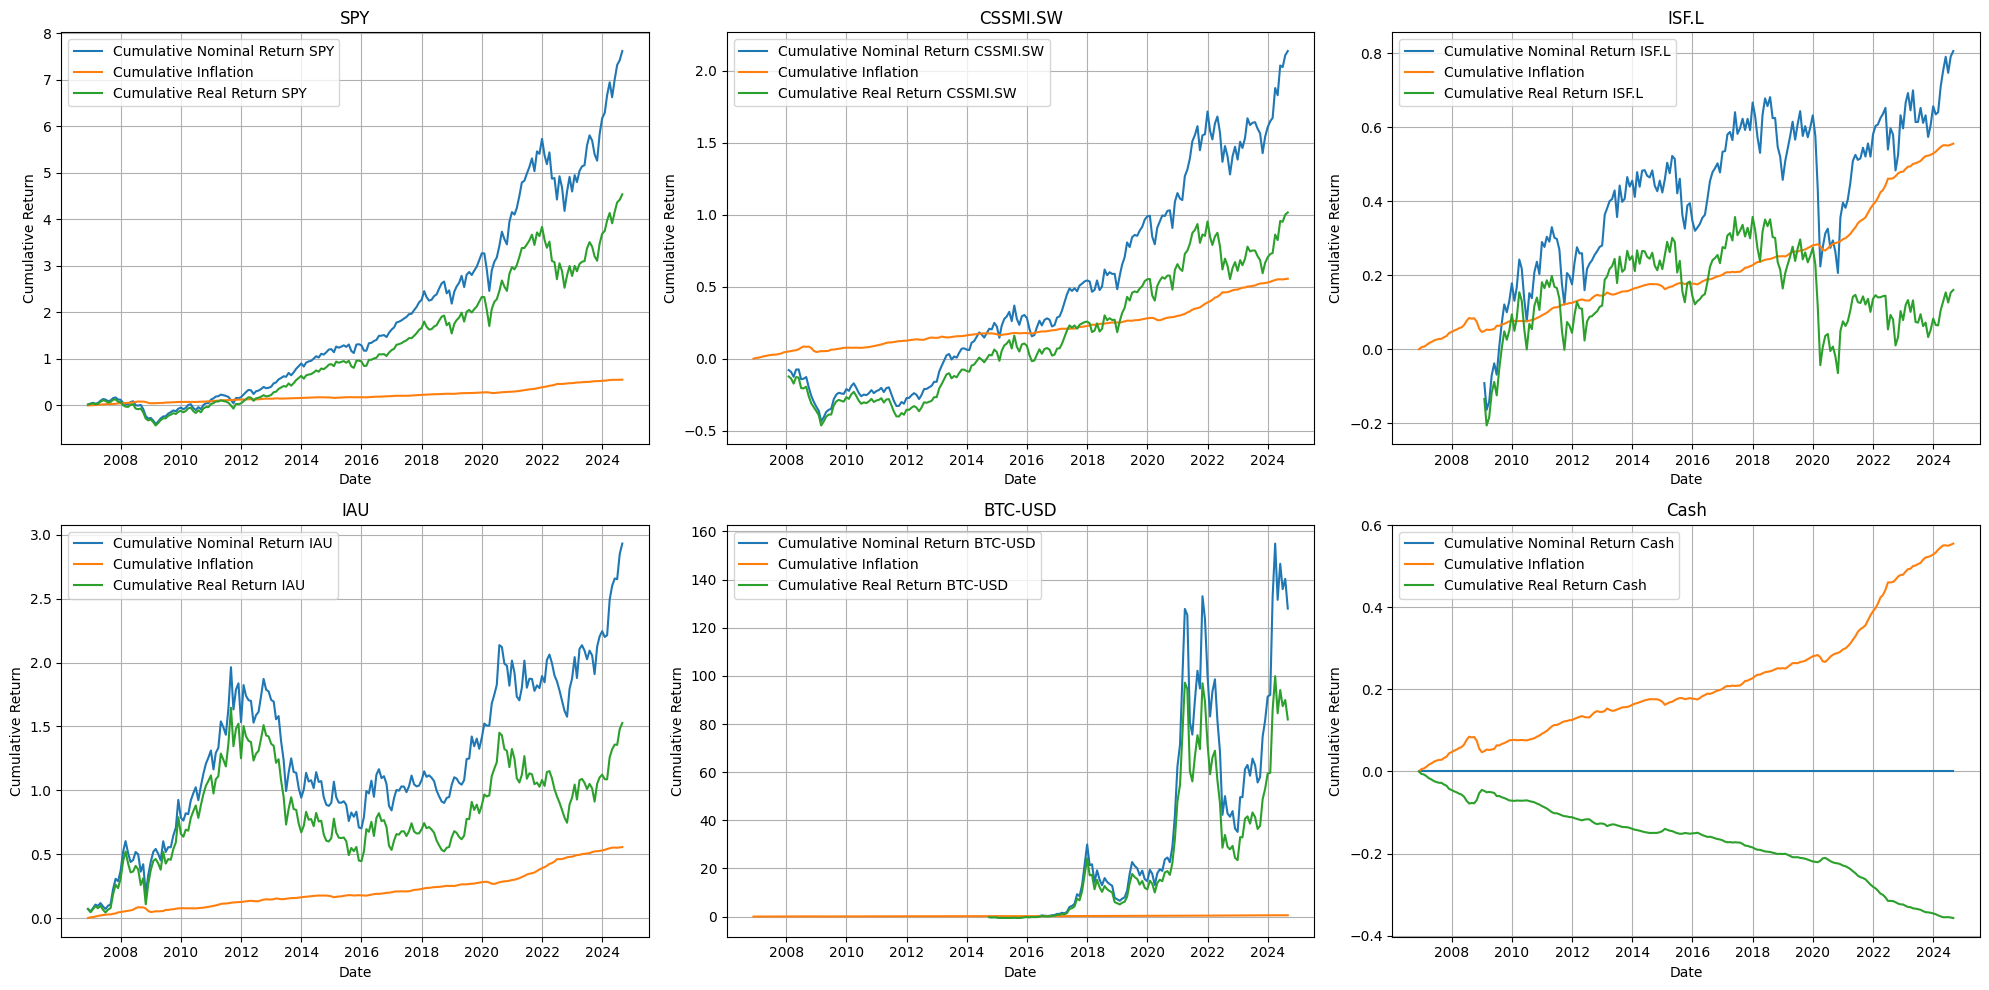

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

axes = axes.flatten()
for i, ticker in enumerate(Tickers):
  ax = axes[i]
  ax.plot(returns_df['DATE'], returns_df[f'CumulativeNominalReturn_{ticker}'], label=f'Cumulative Nominal Return {ticker}')
  ax.plot(returns_df['DATE'], returns_df['CumulativeInflation'], label='Cumulative Inflation')
  ax.plot(returns_df['DATE'], returns_df[f'CumulativeRealReturn_{ticker}'], label=f'Cumulative Real Return {ticker}')

  ax.set_title(f'{ticker}')
  ax.set_xlabel('Date')
  ax.set_ylabel('Cumulative Return')
  ax.legend()
  ax.grid(True)

ax = axes[-1]
ax.plot(returns_df['DATE'], returns_df['CumulativeNominalReturn_Cash'], label='Cumulative Nominal Return Cash')
ax.plot(returns_df['DATE'], returns_df['CumulativeInflation'], label='Cumulative Inflation')
ax.plot(returns_df['DATE'], returns_df['CumulativeRealReturn_Cash'], label='Cumulative Real Return Cash')

ax.set_title('Cash')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [22]:
# Value of an initial investment

initial_investment = 10000  # Example initial investment

# Step 2: Calculate cumulative inflation factor


returns_df['CumulativeInflation'] = (1 + merged_df['InflationRate']).cumprod()

# Step 3: Calculate the nominal and real value of the initial investment

for ticker in Tickers:
    returns_df[f'NominalValue_{ticker}'] = initial_investment * (1 + returns_df[f'CumulativeNominalReturn_{ticker}'])
    returns_df[f'RealValue_{ticker}'] = returns_df[f'NominalValue_{ticker}'] / returns_df['CumulativeInflation']


returns_df['NominalValue_Cash'] = initial_investment * (1 + returns_df['CumulativeNominalReturn_Cash'])
returns_df['RealValue_Cash'] = returns_df['NominalValue_Cash'] / returns_df['CumulativeInflation']


In [23]:
print(returns_df.head())

        DATE  CPIAUCSL       SPY  CSSMI.SW  ISF.L       IAU  BTC-USD  \
1 2006-11-30   202.000  0.019886       NaN    NaN  0.071345      NaN   
2 2006-12-31   203.100  0.021281       NaN    NaN -0.018162      NaN   
3 2007-01-31   203.437  0.015040       NaN    NaN  0.025296      NaN   
4 2007-02-28   204.226 -0.019618       NaN    NaN  0.025135      NaN   
5 2007-03-31   205.288  0.017204       NaN    NaN -0.009777      NaN   

   InflationRate  CumulativeInflation  CumulativeNominalReturn_SPY  ...  \
1       0.000495             1.000495                     0.019886  ...   
2       0.005446             1.005944                     0.041590  ...   
3       0.001659             1.007613                     0.057256  ...   
4       0.003878             1.011521                     0.036515  ...   
5       0.005200             1.016781                     0.054347  ...   

   NominalValue_CSSMI.SW  RealValue_CSSMI.SW  NominalValue_ISF.L  \
1                    NaN                 NaN    

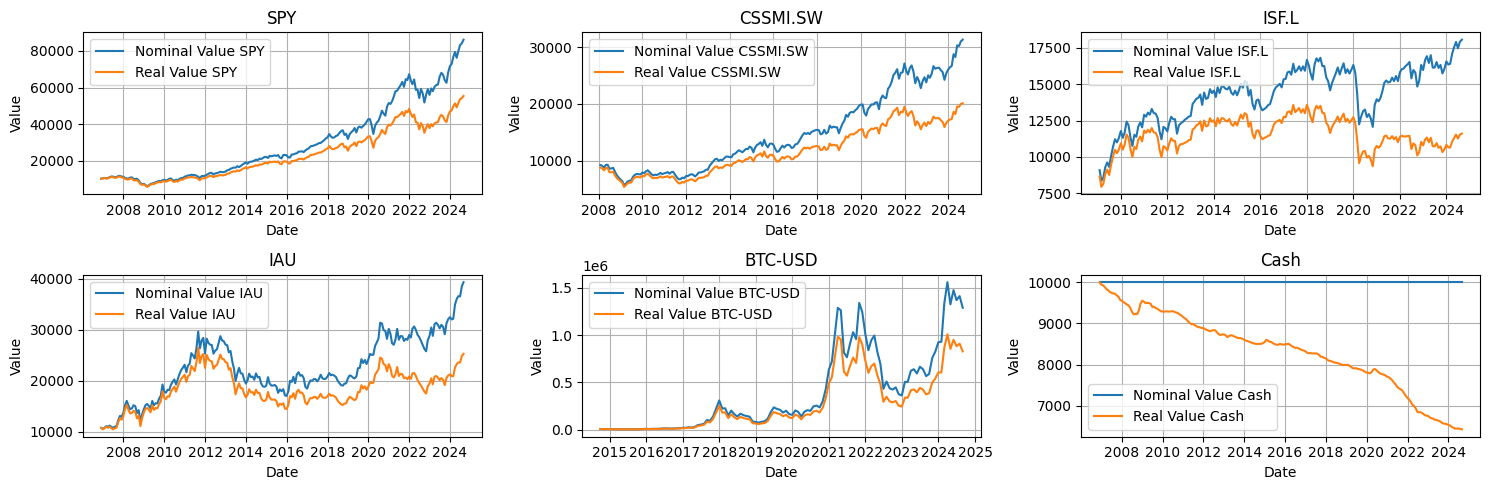

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

axes = axes.flatten()

for i, ticker in enumerate(Tickers):
  ax = axes[i]
  ax.plot(returns_df['DATE'], returns_df[f'NominalValue_{ticker}'], label=f'Nominal Value {ticker}')
  ax.plot(returns_df['DATE'], returns_df[f'RealValue_{ticker}'], label=f'Real Value {ticker}')


  ax.set_title(f'{ticker}')
  ax.set_xlabel('Date')
  ax.set_ylabel('Value')
  ax.legend()
  ax.grid(True)

ax = axes[-1]
ax.plot(returns_df['DATE'], returns_df['NominalValue_Cash'], label='Nominal Value Cash')
ax.plot(returns_df['DATE'], returns_df['RealValue_Cash'], label='Real Value Cash')

ax.set_title('Cash')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


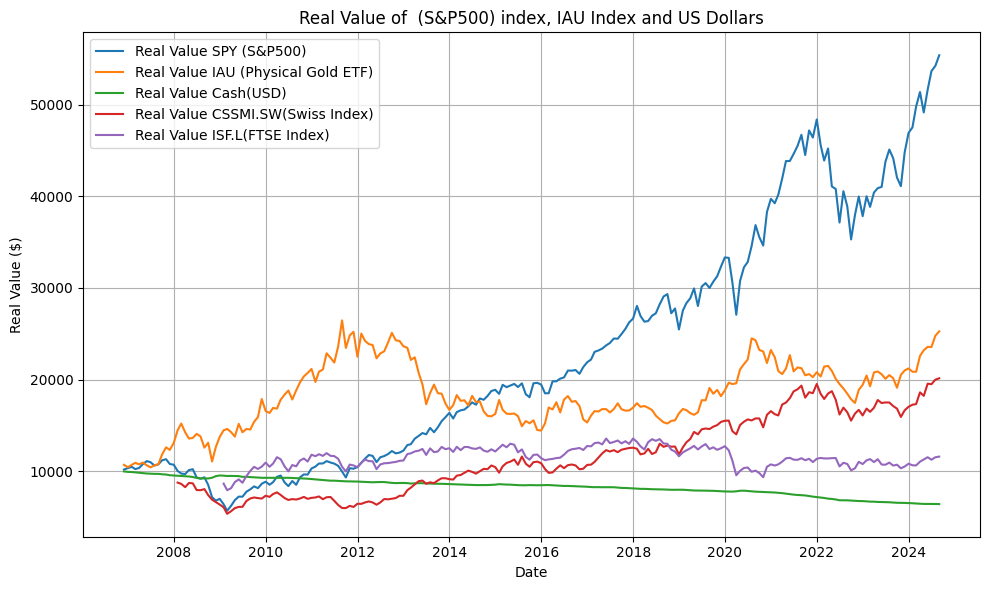

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(returns_df['DATE'], returns_df['RealValue_SPY'], label='Real Value SPY (S&P500)')
ax.plot(returns_df['DATE'], returns_df['RealValue_IAU'], label='Real Value IAU (Physical Gold ETF)')
ax.plot(returns_df['DATE'], returns_df['RealValue_Cash'], label='Real Value Cash(USD)')
ax.plot(returns_df['DATE'], returns_df['RealValue_CSSMI.SW'], label='Real Value CSSMI.SW(Swiss Index)')
ax.plot(returns_df['DATE'], returns_df['RealValue_ISF.L'], label='Real Value ISF.L(FTSE Index)')
#ax.plot(returns_df['DATE'], returns_df['RealValue_BTC-USD'], label='Real Value BTC-USD')


ax.set_title('Real Value of  (S&P500) index, IAU Index and US Dollars')
ax.set_xlabel('Date')
ax.set_ylabel('Real Value ($)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


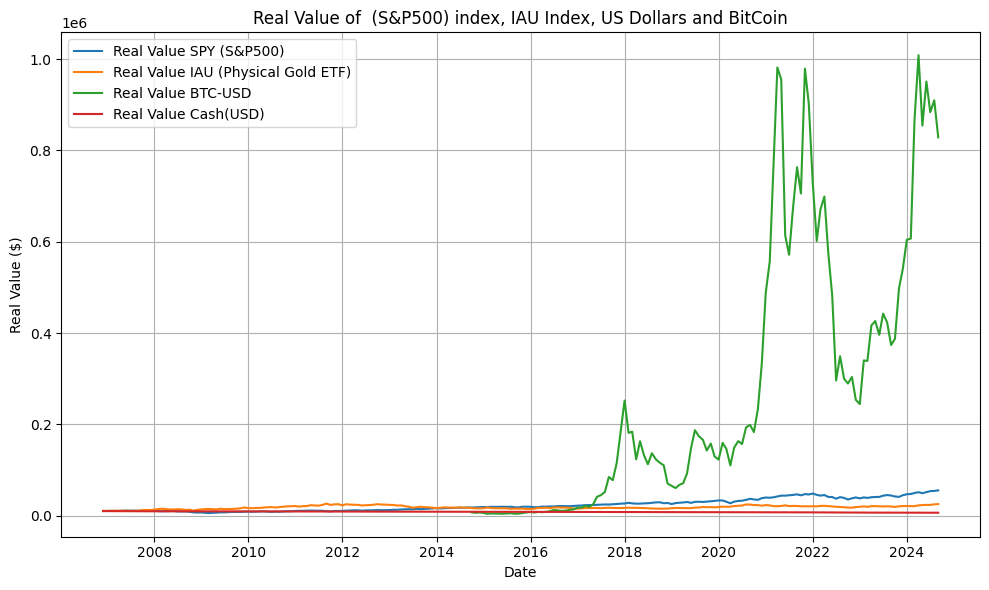

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(returns_df['DATE'], returns_df['RealValue_SPY'], label='Real Value SPY (S&P500)')
ax.plot(returns_df['DATE'], returns_df['RealValue_IAU'], label='Real Value IAU (Physical Gold ETF)')
ax.plot(returns_df['DATE'], returns_df['RealValue_BTC-USD'], label='Real Value BTC-USD')
ax.plot(returns_df['DATE'], returns_df['RealValue_Cash'], label='Real Value Cash(USD)')

ax.set_title('Real Value of  (S&P500) index, IAU Index, US Dollars and BitCoin')
ax.set_xlabel('Date')
ax.set_ylabel('Real Value ($)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# Mean-Var approach portfolio Optimisation

In [27]:
returns_df.head()

,DATE,CPIAUCSL,SPY,CSSMI.SW,ISF.L,IAU,BTC-USD,InflationRate,CumulativeInflation,CumulativeNominalReturn_SPY,...,NominalValue_CSSMI.SW,RealValue_CSSMI.SW,NominalValue_ISF.L,RealValue_ISF.L,NominalValue_IAU,RealValue_IAU,NominalValue_BTC-USD,RealValue_BTC-USD,NominalValue_Cash,RealValue_Cash
1,2006-11-30,202.000,0.019886,NaN,NaN,0.071345,NaN,0.000495,1.000495,0.019886,...,NaN,NaN,NaN,NaN,10713.454016,10708.150326,NaN,NaN,10000,9995.049505
2,2006-12-31,203.100,0.021281,NaN,NaN,-0.018162,NaN,0.005446,1.005944,0.041590,...,NaN,NaN,NaN,NaN,10518.875432,10456.725503,NaN,NaN,10000,9940.915805
3,2007-01-31,203.437,0.015040,NaN,NaN,0.025296,NaN,0.001659,1.007613,0.057256,...,NaN,NaN,NaN,NaN,10784.966109,10703.483916,NaN,NaN,10000,9924.448355
4,2007-02-28,204.226,-0.019618,NaN,NaN,0.025135,NaN,0.003878,1.011521,0.036515,...,NaN,NaN,NaN,NaN,11056.044821,10930.123732,NaN,NaN,10000,9886.106568
5,2007-03-31,205.288,0.017204,NaN,NaN,-0.009777,NaN,0.005200,1.016781,0.054347,...,NaN,NaN,NaN,NaN,10947.946400,10767.265394,NaN,NaN,10000,9834.963563


In [28]:
df_returns = returns_df[['DATE'] + [f'{ticker}' for ticker in Tickers]]
df_returns.dropna(inplace=True)
df_returns.head()

<ipython-input-28-c8a9b0b866dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns.dropna(inplace=True)


,DATE,SPY,CSSMI.SW,ISF.L,IAU,BTC-USD
95,2014-09-30,-0.008293,0.024860,-0.027676,-0.060995,-0.153914
96,2014-10-31,0.023551,-0.003264,-0.010295,-0.029914,-0.125659
97,2014-11-30,0.027472,0.037324,0.019943,-0.005286,0.117421
98,2014-12-31,0.003966,-0.019674,-0.022052,0.013286,-0.153034
99,2015-01-31,-0.029629,-0.064177,0.025464,0.086539,-0.320835


In [29]:
def calculate_volatility(returns_df, ticker, return_type='daily', window=None):
    """
    Calculate historical volatility based on price data.

    Args:
        prices_df (pd.DataFrame): DataFrame containing 'Date' and 'Price' columns.
        return_type (str): Can be 'daily' or 'monthly' for calculating returns.
        window (int): Rolling window for volatility. If None, calculates based on all data.

    Returns:
        float: The annualized historical volatility.
    """


    # Calculate volatility over the specified window or entire data
    if window:
        volatility = returns_df[ticker].rolling(window=window).std()
    else:
        volatility = returns_df[ticker].std()

    # Annualize the volatility
    if return_type == 'daily':
        annualized_volatility = volatility * np.sqrt(252)  # Annualize daily returns
    elif return_type == 'monthly':
        annualized_volatility = volatility * np.sqrt(12)  # Annualize monthly returns
    else:
        raise ValueError("return_type must be 'daily' or 'monthly'")

    return annualized_volatility


def calculate_correlation(returns_df):
    """
    Calculate the correlation matrix between multiple indices.

    Args:
        returns_df (pd.DataFrame): DataFrame with columns representing returns of each index.

    Returns:
        pd.DataFrame: Correlation matrix of returns.
    """
    correlation_matrix = returns_df.corr()
    return correlation_matrix

# Example usage:
# correlation_matrix = calculate_correlation(combined_returns_df)
# print(correlation_matrix)


In [30]:
volatility = []
for ticker in Tickers:
  vol = calculate_volatility(df_returns,ticker, return_type="monthly")
  volatility.append({'Ticker': ticker, 'Volatility': vol})

volatility = pd.DataFrame(volatility)
print(volatility)

     Ticker  Volatility
0       SPY    0.151068
1  CSSMI.SW    0.131504
2     ISF.L    0.120445
3       IAU    0.141046
4   BTC-USD    0.753153


In [31]:
df_returns_no_date = df_returns.drop('DATE', axis=1)
correlation_matrix = df_returns_no_date.corr()
print(correlation_matrix)


               SPY  CSSMI.SW     ISF.L       IAU   BTC-USD
SPY       1.000000  0.709899  0.651649  0.092305  0.341337
CSSMI.SW  0.709899  1.000000  0.628137 -0.057395  0.299115
ISF.L     0.651649  0.628137  1.000000  0.070685  0.325597
IAU       0.092305 -0.057395  0.070685  1.000000  0.101043
BTC-USD   0.341337  0.299115  0.325597  0.101043  1.000000


Here again, we can scale the mean-var approach: we define a mean-var approach class where we take the objective function, the constraints, the optimisation routines and we return all the relevant outputs: efficient frontier for the portfolio, optimal weights,...

In [32]:

# Objective function: minimize portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Constraints: weights must sum to 1
def constraint_sum_of_weights(weights):
    return np.sum(weights) - 1

constraints = {'type': 'eq', 'fun': constraint_sum_of_weights}

n = df_returns.shape[1] - 1  # Number of assets
# Bounds for weights (no short-selling)
bounds = [(0, 1) for _ in range(n)]

# Initial guess for weights (equal allocation)
initial_weights = np.array([1 / n] * n)

print(initial_weights)

# Minimize the portfolio variance

[0.2 0.2 0.2 0.2 0.2]


In [33]:
# Convert the 'Volatility' column to numeric (float) values
volatility['Volatility'] = pd.to_numeric(volatility['Volatility'], errors='coerce')

# Now, you can calculate the outer product (covariance matrix) with the correlation matrix
vol = volatility['Volatility'].values  # Extract volatility values as a NumPy array
print(vol)


[0.1510683  0.13150436 0.1204453  0.14104591 0.75315252]


In [34]:
correlation_matrix.values


array([[ 1.        ,  0.70989886,  0.65164887,  0.09230511,  0.34133709],
       [ 0.70989886,  1.        ,  0.62813705, -0.05739508,  0.29911464],
       [ 0.65164887,  0.62813705,  1.        ,  0.07068508,  0.3255969 ],
       [ 0.09230511, -0.05739508,  0.07068508,  1.        ,  0.10104306],
       [ 0.34133709,  0.29911464,  0.3255969 ,  0.10104306,  1.        ]])

In [35]:
# Compute the covariance matrix
cov_matrix = np.outer(vol, vol) * correlation_matrix.values


## First approach: minimise the risk

In [36]:
# Minimize portfolio variance
result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = result.x
print("Optimal Portfolio Weights:", optimal_weights)

# Combine tickers with their corresponding optimal weights
optimal_portfolio = dict(zip(Tickers, optimal_weights))

# Print the optimal portfolio weights
print("Optimal Portfolio Weights:")
for ticker, weight in optimal_portfolio.items():
    print(f"{ticker}: {weight:.4f}")

Optimal Portfolio Weights: [3.46944695e-18 2.99096456e-01 3.07789835e-01 3.93113709e-01
 5.63785130e-18]
Optimal Portfolio Weights:
SPY: 0.0000
CSSMI.SW: 0.2991
ISF.L: 0.3078
IAU: 0.3931
BTC-USD: 0.0000


In [37]:
df_returns.head()

,DATE,SPY,CSSMI.SW,ISF.L,IAU,BTC-USD
95,2014-09-30,-0.008293,0.024860,-0.027676,-0.060995,-0.153914
96,2014-10-31,0.023551,-0.003264,-0.010295,-0.029914,-0.125659
97,2014-11-30,0.027472,0.037324,0.019943,-0.005286,0.117421
98,2014-12-31,0.003966,-0.019674,-0.022052,0.013286,-0.153034
99,2015-01-31,-0.029629,-0.064177,0.025464,0.086539,-0.320835


## Second approach: maximise the returns with a given variance constraint

In [38]:
# Remove the 'Date' column and work only with the returns data
returns_data = df_returns.drop(columns=['DATE']).values  # Only non-date columns (returns for indices)

# Calculate expected returns and covariance matrix
expected_returns = np.mean(returns_data, axis=0)  # Historical mean returns for each asset
cov_matrix = np.cov(returns_data, rowvar=False)  # Covariance matrix for the assets
target_volatility = 0.08  # Example volatility constraint (15% annual volatility)

# Objective function: negative portfolio return (since we want to maximize returns)
def portfolio_return(weights, expected_returns):
    return -np.dot(weights, expected_returns)

# Constraint: portfolio volatility must be below the target
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Initial weights (starting guess for optimization)
n_assets = returns_data.shape[1]  # Number of assets (indices)
initial_weights = np.ones(n_assets) / n_assets  # Equal weight initialization

# Constraints: weights sum to 1 and volatility must be below the threshold
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights = 1
               {'type': 'ineq', 'fun': lambda weights: target_volatility - portfolio_volatility(weights, cov_matrix)}]



# Bounds: weights between 0 and 1 (no shorting)
bounds = [(0, 1) for _ in range(n_assets)]

# Optimize: maximize portfolio return subject to constraints
result = minimize(portfolio_return, initial_weights, args=(expected_returns,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = result.x

# Combine tickers with weights
tickers = df_returns.columns[1:]  # Exclude the 'Date' column
optimal_portfolio = dict(zip(tickers, optimal_weights))

# Display the optimal portfolio
print("Optimal Portfolio Weights with Volatility Constraint:")
for ticker, weight in optimal_portfolio.items():
    print(f"{ticker}: {weight:.4f}")

# Calculate the resulting portfolio return and volatility
final_return = -portfolio_return(optimal_weights, expected_returns)
final_volatility = portfolio_volatility(optimal_weights, cov_matrix)

print(f"Expected Portfolio Return: {final_return:.4f}")
print(f"Expected Portfolio Volatility: {final_volatility:.4f}")

Optimal Portfolio Weights with Volatility Constraint:
SPY: 0.6782
CSSMI.SW: 0.0000
ISF.L: 0.0000
IAU: 0.0238
BTC-USD: 0.2980
Expected Portfolio Return: 0.0275
Expected Portfolio Volatility: 0.0800


In [39]:
# Assuming optimal_portfolio is a dictionary like {'Ticker1': weight1, 'Ticker2': weight2, ...}
optimal_portfolio_df = pd.DataFrame.from_dict(optimal_portfolio, orient='index', columns=['Weight'])

# Reset the index to have the tickers as a column
optimal_portfolio_df = optimal_portfolio_df.reset_index().rename(columns={'index': 'Ticker'})

print(optimal_portfolio_df)


     Ticker        Weight
0       SPY  6.782018e-01
1  CSSMI.SW  4.666406e-16
2     ISF.L  0.000000e+00
3       IAU  2.378363e-02
4   BTC-USD  2.980145e-01


## Visualization: efficient frontier

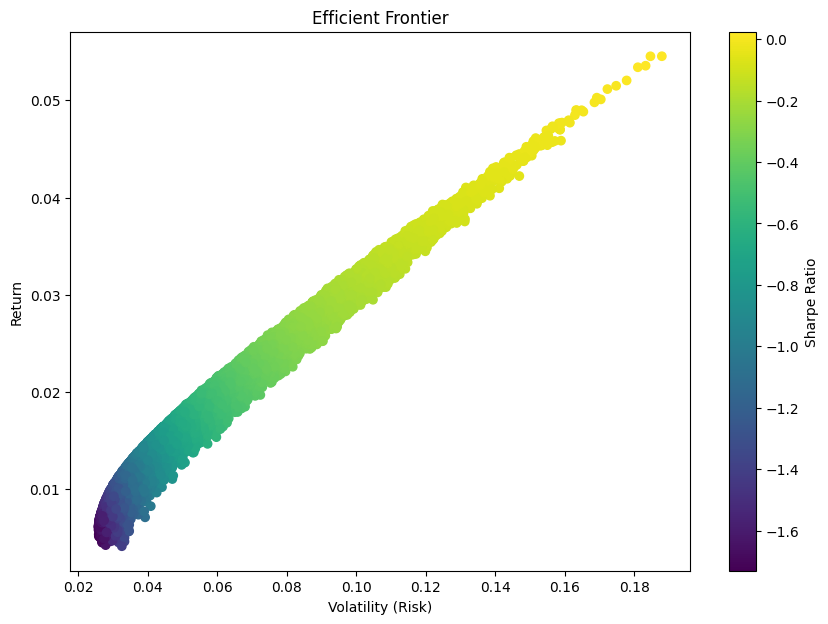

In [40]:


# Calculate mean returns and covariance matrix
mean_returns = expected_returns
#cov_matrix = returns_df.cov()

# Number of portfolios to simulate
num_portfolios = 100000
risk_free_rate = 0.05  # Assuming 1% risk-free rate

# Arrays to store simulation results
port_returns = []
port_volatilities = []
port_sharpe_ratios = []
port_weights = []

# Loop to simulate portfolios
for _ in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)  # Normalize weights to sum to 1

    # Portfolio return and volatility
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Store results
    port_returns.append(portfolio_return)
    port_volatilities.append(portfolio_volatility)
    port_sharpe_ratios.append(sharpe_ratio)
    port_weights.append(weights)

# Convert lists to arrays
port_returns = np.array(port_returns)
port_volatilities = np.array(port_volatilities)
port_sharpe_ratios = np.array(port_sharpe_ratios)

# Plot the Efficient Frontier
plt.figure(figsize=(10, 7))
plt.scatter(port_volatilities, port_returns, c=port_sharpe_ratios, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.show()


# Buy and Hold:

In [41]:
# Recall the returns data frame
print("Historical returns :\n")
print(df_returns.head())
# Recall the optimal weights
print("\nOptimal weights :\n")
print(optimal_portfolio_df)

Historical returns :

         DATE       SPY  CSSMI.SW     ISF.L       IAU   BTC-USD
95 2014-09-30 -0.008293  0.024860 -0.027676 -0.060995 -0.153914
96 2014-10-31  0.023551 -0.003264 -0.010295 -0.029914 -0.125659
97 2014-11-30  0.027472  0.037324  0.019943 -0.005286  0.117421
98 2014-12-31  0.003966 -0.019674 -0.022052  0.013286 -0.153034
99 2015-01-31 -0.029629 -0.064177  0.025464  0.086539 -0.320835

Optimal weights :

     Ticker        Weight
0       SPY  6.782018e-01
1  CSSMI.SW  4.666406e-16
2     ISF.L  0.000000e+00
3       IAU  2.378363e-02
4   BTC-USD  2.980145e-01


In [42]:
returns_df.head()

,DATE,CPIAUCSL,SPY,CSSMI.SW,ISF.L,IAU,BTC-USD,InflationRate,CumulativeInflation,CumulativeNominalReturn_SPY,...,NominalValue_CSSMI.SW,RealValue_CSSMI.SW,NominalValue_ISF.L,RealValue_ISF.L,NominalValue_IAU,RealValue_IAU,NominalValue_BTC-USD,RealValue_BTC-USD,NominalValue_Cash,RealValue_Cash
1,2006-11-30,202.000,0.019886,NaN,NaN,0.071345,NaN,0.000495,1.000495,0.019886,...,NaN,NaN,NaN,NaN,10713.454016,10708.150326,NaN,NaN,10000,9995.049505
2,2006-12-31,203.100,0.021281,NaN,NaN,-0.018162,NaN,0.005446,1.005944,0.041590,...,NaN,NaN,NaN,NaN,10518.875432,10456.725503,NaN,NaN,10000,9940.915805
3,2007-01-31,203.437,0.015040,NaN,NaN,0.025296,NaN,0.001659,1.007613,0.057256,...,NaN,NaN,NaN,NaN,10784.966109,10703.483916,NaN,NaN,10000,9924.448355
4,2007-02-28,204.226,-0.019618,NaN,NaN,0.025135,NaN,0.003878,1.011521,0.036515,...,NaN,NaN,NaN,NaN,11056.044821,10930.123732,NaN,NaN,10000,9886.106568
5,2007-03-31,205.288,0.017204,NaN,NaN,-0.009777,NaN,0.005200,1.016781,0.054347,...,NaN,NaN,NaN,NaN,10947.946400,10767.265394,NaN,NaN,10000,9834.963563


In [43]:
# Create a new DataFrame with the 'Date' column as the index
new_df_returns = df_returns.set_index('DATE')

# Print the new DataFrame
print(new_df_returns.head())


                 SPY  CSSMI.SW     ISF.L       IAU   BTC-USD
DATE                                                        
2014-09-30 -0.008293  0.024860 -0.027676 -0.060995 -0.153914
2014-10-31  0.023551 -0.003264 -0.010295 -0.029914 -0.125659
2014-11-30  0.027472  0.037324  0.019943 -0.005286  0.117421
2014-12-31  0.003966 -0.019674 -0.022052  0.013286 -0.153034
2015-01-31 -0.029629 -0.064177  0.025464  0.086539 -0.320835


In [44]:
df_returns_no_date = df_returns.drop(columns='DATE')
df_returns_no_date.head()
df_returns_no_date.reset_index(drop=True, inplace=True)
df_returns_no_date.head()

,SPY,CSSMI.SW,ISF.L,IAU,BTC-USD
0,-0.008293,0.024860,-0.027676,-0.060995,-0.153914
1,0.023551,-0.003264,-0.010295,-0.029914,-0.125659
2,0.027472,0.037324,0.019943,-0.005286,0.117421
3,0.003966,-0.019674,-0.022052,0.013286,-0.153034
4,-0.029629,-0.064177,0.025464,0.086539,-0.320835


In [45]:

def buy_and_hold_strategy(initial_weights_df, initial_investment, returns_df):
    """
    Simulate a buy-and-hold strategy with reinvestment of dividends.

    Parameters:
    - initial_weights_df: pd.DataFrame with 'Ticker' and 'Weight' columns.
    - initial_investment: float, the total initial amount of capital.
    - returns_df: pd.DataFrame with 'Date' as index and asset returns as columns.

    Returns:
    - portfolio_value_history: pd.Series representing the portfolio value over time.
    """

    # Initialize portfolio value
    portfolio_value = initial_investment

    # Convert initial weights DataFrame to a dictionary for easier access
    initial_weights = dict(zip(initial_weights_df['Ticker'], initial_weights_df['Weight']))

    # Initialize a Series to track portfolio value over time
    portfolio_value_history = pd.Series(index=returns_df.index, dtype=float)

    # Allocate initial investment based on the weights
    portfolio_allocation = {ticker: initial_investment * weight for ticker, weight in initial_weights.items()}

    # Iterate over each date in the returns DataFrame
    for date, returns in returns_df.iterrows():
        #print(date)
        #print(returns)
        #print(returns.index)
        # Update the portfolio allocation for each asset based on the returns
        for ticker in initial_weights.keys():
            if ticker in returns.index and not pd.isna(returns[ticker]):  # Ensure the ticker is in returns and not NaN
                #print(f"Ticker: {ticker}, Return: {returns[ticker]}")
                portfolio_allocation[ticker] *= (1 + returns[ticker])

        # Calculate the total portfolio value at the current date
        portfolio_value = sum(portfolio_allocation.values())

        # Store the portfolio value in the history
        portfolio_value_history[date] = portfolio_value

    return portfolio_value_history


Text(0.5, 0, 'Date')

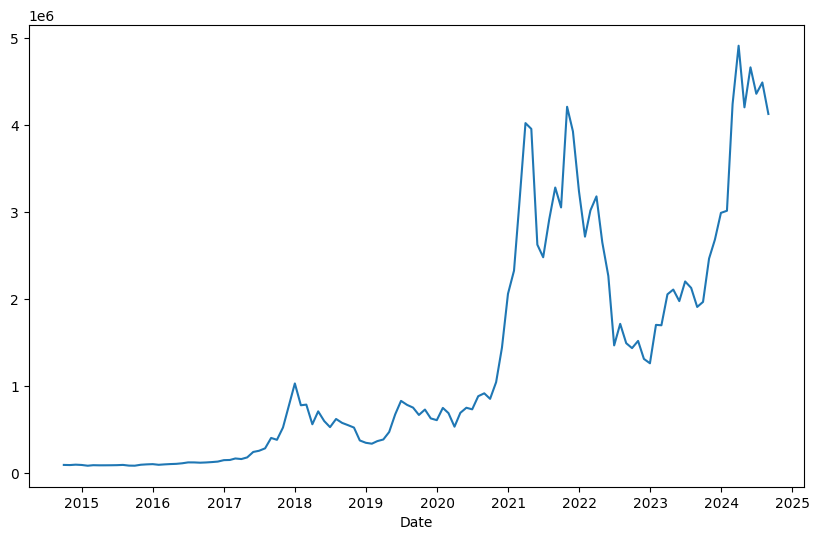

In [46]:
# Buy_and_hold_strategy

initial_investment = 100000  # Example initial investment
portfolio_value_history = buy_and_hold_strategy(optimal_portfolio_df, initial_investment, new_df_returns)

# plot the portfolio value over time

plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_history.index, portfolio_value_history.values, label='Portfolio Value')
plt.xlabel('Date')




In [47]:
class BuyAndHoldStrategy:
    def __init__(self, initial_weights_df, initial_investment, returns_df, risk_free_rate=0.1, benchmark_returns = None):
        """
        Initialize the Buy and Hold Strategy.

        Parameters:
        - initial_weights_df: pd.DataFrame with 'Ticker' and 'Weight' columns.
        - initial_investment: float, the total initial amount of capital.
        - returns_df: pd.DataFrame with 'Date' as index and asset returns as columns.
        """
        self.initial_weights_df = initial_weights_df
        self.initial_investment = initial_investment
        self.returns_df = returns_df
        self.portfolio_value_history = None
        self.cumulative_returns = None
        self.final_portfolio_value = None
        self.risk_free_rate = risk_free_rate
        self.benchmark_returns = benchmark_returns

    def run_strategy(self):
        """
        Run the buy-and-hold strategy and calculate the portfolio's value over time and cumulative returns.
        """
        # Initialize portfolio value and allocate based on weights
        portfolio_value = self.initial_investment
        initial_weights = dict(zip(self.initial_weights_df['Ticker'], self.initial_weights_df['Weight']))
        portfolio_allocation = {ticker: portfolio_value * weight for ticker, weight in initial_weights.items()}

        # Initialize Series to track portfolio value and cumulative returns
        self.portfolio_value_history = pd.Series(index=self.returns_df.index, dtype=float)
        self.cumulative_returns = pd.Series(index=self.returns_df.index, dtype=float)

        # Iterate over each date in the returns DataFrame
        for date, returns in self.returns_df.iterrows():
            # Update the portfolio allocation for each asset based on returns
            for ticker in initial_weights.keys():
                if ticker in returns.index and not pd.isna(returns[ticker]):
                    portfolio_allocation[ticker] *= (1 + returns[ticker])

            # Calculate the total portfolio value at the current date
            portfolio_value = sum(portfolio_allocation.values())
            self.portfolio_value_history[date] = portfolio_value
            self.cumulative_returns[date] = (portfolio_value / self.initial_investment) - 1

        self.final_portfolio_value = portfolio_value

    def calculate_portfolio_beta(self):
        """
        Calculate the beta of the portfolio relative to a benchmark.

        Returns:
        - portfolio_beta: float, the beta of the portfolio.
        """
        # Ensure benchmark returns are provided
        if self.benchmark_returns is None:
            raise ValueError("Benchmark returns must be provided to calculate portfolio beta.")

        # Initialize beta calculation
        portfolio_beta = 0

        # Calculate beta for each asset in the portfolio
        initial_weights = dict(zip(self.initial_weights_df['Ticker'], self.initial_weights_df['Weight']))
        for ticker, weight in initial_weights.items():
            if ticker in self.returns_df.columns:
                # Covariance between the asset and benchmark
                cov_matrix = np.cov(self.returns_df[ticker], self.benchmark_returns)
                cov = cov_matrix[0, 1]  # Covariance between asset and benchmark
                var_market = np.var(self.benchmark_returns)  # Variance of the benchmark
                beta_i = cov / var_market  # Beta of the asset
                portfolio_beta += weight * beta_i  # Weighted beta contribution

        return portfolio_beta

    def get_portfolio_value_history(self):
        """
        Get the history of portfolio values over time.
        """
        return self.portfolio_value_history

    def get_cumulative_returns(self):
        """
        Get the cumulative returns over time.
        """
        return self.cumulative_returns

    def calculate_sharpe_ratio(self):
        """
        Calculate the Sharpe Ratio of the portfolio.

        Returns:
        - Sharpe ratio: float
        """
        # Daily excess returns = portfolio return - risk-free rate (converted to daily rate)
        excess_returns = self.cumulative_returns - (self.risk_free_rate / 252)  # Assuming 252 trading days
        #print(excess_returns)
        sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
        return sharpe_ratio

    def plot_cumulative_returns(self):
        """
        Plot the cumulative returns of the portfolio over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.cumulative_returns.index, self.cumulative_returns, label="Cumulative Returns")
        plt.title("Portfolio Cumulative Returns Over Time")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.grid(True)
        plt.show()


    def get_performance_summary(self):
        """
        Get a summary of the strategy's performance, including final portfolio value and total return.
        """
        total_return = self.cumulative_returns.iloc[-1] * 100
        sharpe_ratio = self.calculate_sharpe_ratio()
        summary = {
            "Final Portfolio Value": self.final_portfolio_value,
            "Total Return (%)": total_return,
            "Sharpe Ratio": sharpe_ratio
        }
        return summary


Portfolio Beta: 1.1973727490607589
{'Final Portfolio Value': 4123965.8238947624, 'Total Return (%)': 4023.9658238947627, 'Sharpe Ratio': 14.29829909633296}


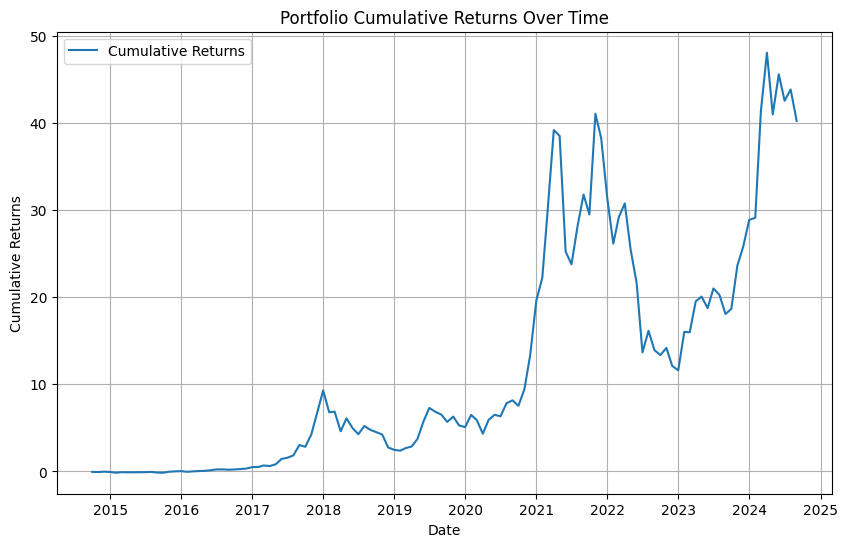

In [48]:
# Create the strategy object
rf = 0.01
benchmark_returns = pd.Series(new_df_returns['SPY'], index=new_df_returns.index)
strategy = BuyAndHoldStrategy(optimal_portfolio_df, initial_investment, new_df_returns, rf, benchmark_returns)



# Calculate portfolio beta
portfolio_beta = strategy.calculate_portfolio_beta()
print(f"Portfolio Beta: {portfolio_beta}")


# Run the strategy
strategy.run_strategy()

 # Run the strategy
strategy.run_strategy()

# Get performance summary
print(strategy.get_performance_summary())

# Plot cumulative returns
strategy.plot_cumulative_returns()

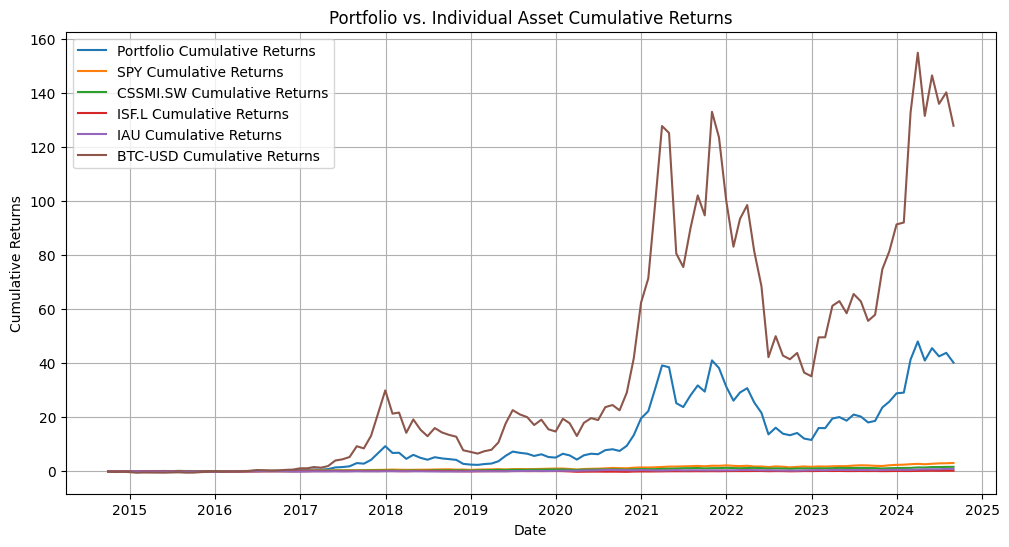

In [49]:
plt.figure(figsize=(12, 6))

# Plot the cumulative returns of the portfolio
plt.plot(strategy.get_cumulative_returns(), label='Portfolio Cumulative Returns')

# Plot the cumulative returns of each asset in the portfolio
for ticker in optimal_portfolio_df['Ticker']:
    cumulative_asset_returns = (1 + new_df_returns[ticker]).cumprod() - 1
    plt.plot(cumulative_asset_returns, label=f'{ticker} Cumulative Returns')

plt.title('Portfolio vs. Individual Asset Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


# Dollar Cost Averaging(DCA):

In [81]:
class DCAInvestmentStrategy:
    def __init__(self, initial_weights_df, initial_investment,returns_df, monthly_contribution = 0,risk_free_rate=0.01, benchmark_returns = None):
        """
        Initialize the Buy and Hold Strategy.

        Parameters:
        - initial_weights_df: pd.DataFrame with 'Ticker' and 'Weight' columns.
        - initial_investment: float, the total initial amount of capital.
        - returns_df: pd.DataFrame with 'Date' as index and asset returns as columns.
        - monthly_contribution: The fixed monthly contribution.
        """
        self.initial_weights_df = initial_weights_df
        self.initial_investment = initial_investment
        self.returns_df = returns_df # Periodic returns of the assets composing the portfolio
        self.monthly_contribution = monthly_contribution # Fixed monthly contribution to the portfolio
        self.portfolio_value_history = None # pd.Series to store the partfolio_value at the end of each holding period
        self.cumulative_returns = None # pd.Series to store the cumulative returns without adjusting to cash inflows
        self.final_portfolio_value = None # the portfolio_value at the end of the backtesting window
        self.risk_free_rate = risk_free_rate
        self.benchmark_returns = benchmark_returns
        self.total_contribution = 0
        self.total_contributions = initial_investment
        self.adjusted_returns = None # pd.Series to store the adjusted periodic returns to cash inflows
        self.adjusted_cumulative_returns = None # pd.Series to store the adjusted cumulative returns to cash inflows, this is the time weighted returns over period [0, t]


    def run_strategy(self):
        """
        Run the dollar cost averaging strategy and calculate the portfolio's value over time and cumulative returns.
        """
        # Initialize portfolio value and allocate based on weights


        portfolio_value = self.initial_investment
        initial_weights = dict(zip(self.initial_weights_df['Ticker'], self.initial_weights_df['Weight']))
        portfolio_allocation = {ticker: portfolio_value * weight for ticker, weight in initial_weights.items()}

        # Initialize Series to track portfolio value and returns


        self.portfolio_value_history = pd.Series(index=self.returns_df.index, dtype=float)
        self.cumulative_returns = pd.Series(index=self.returns_df.index, dtype=float)
        self.adjusted_returns = pd.Series(index=self.returns_df.index, dtype=float)
        self.adjusted_cumulative_returns = pd.Series(index=self.returns_df.index, dtype=float)

        # It is assumed that the monthly contribution is equally allocated among the assets in the portfolio
        N_assets = len(initial_weights)
        Value_add_on= self.monthly_contribution / N_assets


        previous_portfolio_value = self.initial_investment

        # Iterate over each date in the returns DataFrame

        for date, returns in self.returns_df.iterrows():
            # A small description of the process
            # previous_value = portfolio_value
            # start_value = previous_value + contribution
            # end_value = start_value*Return
            # adjusted_return = (end_value - start_value)/start_value
            # portfolio_value = end_value

            self.total_contribution += self.monthly_contribution


            # Calculate the value or the portfolio at the start of the period, after adding the contributions
            start_value = previous_portfolio_value + self.monthly_contribution

            # Update the portfolio allocation for each asset based on returns. The contributions are invested using DCA strategy
            for ticker in initial_weights.keys():
                if ticker in returns.index and not pd.isna(returns[ticker]):

                    portfolio_allocation[ticker] *= (1 + returns[ticker])
                    portfolio_allocation[ticker] += Value_add_on # Here the contribution is allocated equally among assets

            # Calculate the total portfolio value at the current date
            end_value = sum(portfolio_allocation.values())
            portfolio_value = end_value

            # Calculate the portfolio_adjusted returns (not cumulative)

            self.adjusted_returns[date] = (end_value - start_value)/start_value
            # Store the portfolio value in the history
            self.portfolio_value_history[date] = portfolio_value
            #self.adjusted_returns[date] = (portfolio_value - previous_portfolio_value - self.monthly_contribution) / (previous_portfolio_value+self.monthly_contribution)
            # Store the previous_portfolio_value
            previous_portfolio_value = portfolio_value
            self.cumulative_returns[date] = (portfolio_value / self.initial_investment) - 1

        # Calculate the capital_at_risk during the backtesting period
        self.total_contributions += self.total_contribution

        # Get the final portfolio_value
        self.final_portfolio_value = portfolio_value

        # Get the time weighted returns
        self.adjusted_cumulative_returns = (1 + self.adjusted_returns).cumprod() - 1


    def get_adjusted_cumulative_returns(self):
        """
        Get the adjusted cumulative returns over time.
        """
        return self.adjusted_cumulative_returns


    def get_adjusted_returns(self):
        """
        Get the history of portfolio adjusted returns over time.
        """
        return self.adjusted_returns

    def get_cumulative_returns(self):
        """
        Get the cumulative returns over time.
        """
        return self.cumulative_returns


    def get_total_contributions(self):
        """
        Get the total sum of contributions made to the portfolio over time.
        """
        return self.total_contribution

    def get_capital_at_risk(self):
        """
        Get the total capital at risk during the backtesting window.
        """
        return self.total_contributions


    def calculate_total_return(self):
        """
        Calculate the total return from the DCA strategy.

        Returns:
        - total_return: float, the total return as a percentage.
        """

        total_return = ((self.final_portfolio_value - self.total_contributions) / self.total_contributions) * 100
        return total_return


    def get_portfolio_value_history(self):
        """
        Get the history of portfolio values over time.
        """
        return self.portfolio_value_history



    def calculate_sharpe_ratio(self):
        """
        Calculate the Sharpe Ratio of the portfolio.

        Returns:
        - Sharpe ratio: float
        """
        # Daily excess returns = portfolio return - risk-free rate (converted to daily rate)
        excess_returns = self.cumulative_returns - (self.risk_free_rate / 252)  # Assuming 252 trading days
        #print(excess_returns)
        sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
        return sharpe_ratio

    def plot_cumulative_returns(self):
        """
        Plot the cumulative returns of the portfolio over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.adjusted_cumulative_returns.index, self.adjusted_cumulative_returns, label="Adjusted Cumulative Returns")
        plt.title("Portfolio Cumulative Returns Over Time")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.grid(True)
        plt.show()


    def get_performance_summary(self):
        """
        Get a summary of the strategy's performance, including final portfolio value and total return.
        """
        adjusted_total_return = self.adjusted_cumulative_returns.iloc[-1] * 100
        total_return = self.calculate_total_return()
        sharpe_ratio = self.calculate_sharpe_ratio()
        summary = {
            "Final Portfolio Value": self.final_portfolio_value,
            "Adjusted Total Return (%)": adjusted_total_return,
            "Total Return (%)": total_return,
            "Sharpe Ratio": sharpe_ratio
        }
        return summary


In [86]:
weights = optimal_portfolio_df.copy()
weights['Weight'] = [0, 0, 0, 1, 0]
print(weights)



     Ticker  Weight
0       SPY       0
1  CSSMI.SW       0
2     ISF.L       0
3       IAU       1
4   BTC-USD       0


In [90]:
# prompt: remove the BTC columns froù new df returns. store in new df

new_df_returns_no_BTC = new_df_returns.drop('BTC-USD', axis=1)
weights_no_BTC = weights.drop(weights[weights['Ticker'] == 'BTC-USD'].index)
print(new_df_returns_no_BTC)
print(weights_no_BTC)


                 SPY  CSSMI.SW     ISF.L       IAU
DATE                                              
2014-09-30 -0.008293  0.024860 -0.027676 -0.060995
2014-10-31  0.023551 -0.003264 -0.010295 -0.029914
2014-11-30  0.027472  0.037324  0.019943 -0.005286
2014-12-31  0.003966 -0.019674 -0.022052  0.013286
2015-01-31 -0.029629 -0.064177  0.025464  0.086539
...              ...       ...       ...       ...
2024-04-30 -0.040320 -0.017379  0.025219  0.030707
2024-05-31  0.050580  0.072883  0.021335  0.015935
2024-06-30  0.038635 -0.003508 -0.024178 -0.001364
2024-07-31  0.012109  0.026909  0.025318  0.053949
2024-08-31  0.023366  0.009554  0.008108  0.021166

[120 rows x 4 columns]
     Ticker  Weight
0       SPY       0
1  CSSMI.SW       0
2     ISF.L       0
3       IAU       1


{'Final Portfolio Value': 399353.10341542726, 'Adjusted Total Return (%)': 96.61904706296475, 'Total Return (%)': 81.5241379161033, 'Sharpe Ratio': 19.84576307872834}


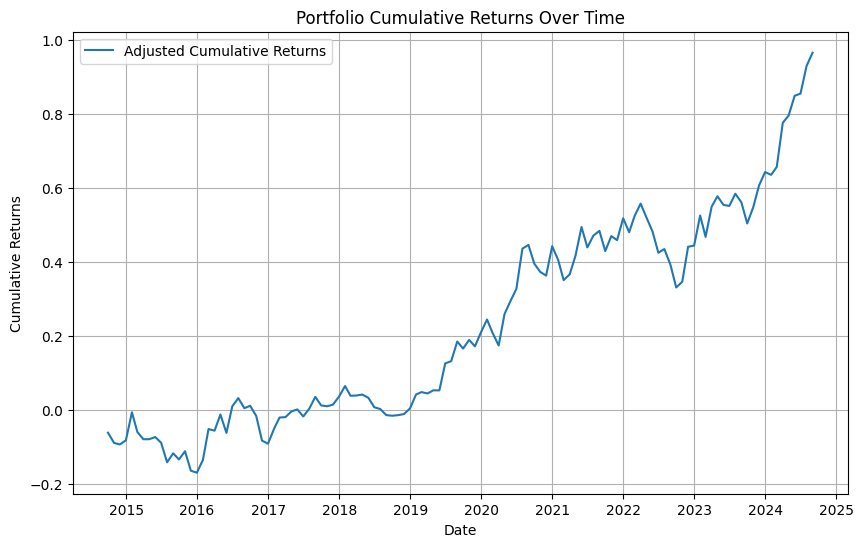

In [91]:
# Run the DCA strategy

# Create the strategy object
rf = 0.01
monthly_contribution = 1000
#benchmark_returns = pd.Series(new_df_returns['SPY'], index=new_df_returns.index)
#DCA_strategy = DCAInvestmentStrategy(weights, initial_investment, new_df_returns, monthly_contribution, rf)
DCA_strategy = DCAInvestmentStrategy(weights_no_BTC, initial_investment, new_df_returns_no_BTC, monthly_contribution, rf)

# Run the strategy
DCA_strategy.run_strategy()

# Get performance summary
print(DCA_strategy.get_performance_summary())

# Plot cumulative returns
DCA_strategy.plot_cumulative_returns()


In [92]:

DCA_performance_summary = DCA_strategy.get_performance_summary()
DCA_final_portfolio_value = DCA_performance_summary["Final Portfolio Value"]
print(f"Final Portfolio Value (DCA): {DCA_final_portfolio_value}")

Buy_hold_performance_summary = strategy.get_performance_summary()
Buy_hold_final_portfolio_value = Buy_hold_performance_summary["Final Portfolio Value"]
print(f"Final Portfolio Value (BAH): {Buy_hold_final_portfolio_value}")

# Difference between the final values
difference = DCA_final_portfolio_value - Buy_hold_final_portfolio_value
print(f"Difference: {difference}")

Final Portfolio Value (DCA): 399353.10341542726
Final Portfolio Value (BAH): 4123965.8238947624
Difference: -3724612.720479335


In [93]:
DCA_total_return = DCA_strategy.calculate_total_return()
print(f"Total Return: {DCA_total_return}%")

Total Return: 81.5241379161033%


In [117]:

def npv(cashflows, rate):
    """
    Calculate the Net Present Value (NPV) given a series of cash flows and a discount rate.

    Parameters:
    - cashflows: list of cash flows, where the first value is the initial investment (negative) and
                 subsequent values are the cash inflows (positive) or outflows (negative).
    - rate: The discount rate used to calculate the present value.

    Returns:
    - NPV: The net present value.
    """
    return sum([cf * (1 + rate) ** (len(cashflows)-1 - i) for i, cf in enumerate(cashflows)])

def irr_solver(cashflows,final_value, guess=0.1):
    """
    Solve for the Internal Rate of Return (IRR) that makes the NPV of cash flows equal to zero.

    Parameters:
    - cashflows: list of cash flows, where the first value is the initial investment (negative) and
                 subsequent values are the cash inflows (positive) or outflows (negative).
    - guess: initial guess for the IRR (default 0.1 or 10%)

    Returns:
    - IRR: The internal rate of return.
    """
    # Define the equation to solve: npv(cashflows, rate) = 0
    def equation(rate):
        return npv(cashflows, rate)-final_value

    # Use fsolve to solve the equation
    irr = fsolve(equation, guess)[0]

    return irr

# Example Test Case
#cashflows = [-10000, 5000, 5000, 5000]  # Initial investment and subsequent inflows
#irr = irr_solver(cashflows)
#print(f"Internal Rate of Return: {irr * 100:.3f}%")


In [111]:
[ (len(cashflows)-1 - i) for i, cf in enumerate(cashflows)]

[3, 2, 1, 0]

In [114]:
# Assuming 'new_df_returns' is your DataFrame with returns and dates as index
contributions_df = pd.DataFrame(index=new_df_returns.index)

# Initial contribution is initial investment + monthly contribution
contributions_df['Contribution'] = 0
# Initial contribution is initial investment + monthly contribution
contributions_df.loc[contributions_df.index[0], 'Contribution'] = DCA_strategy.initial_investment + DCA_strategy.monthly_contribution

# Subsequent contributions are monthly contributions
contributions_df.loc[contributions_df.index[1:], 'Contribution'] = DCA_strategy.monthly_contribution

print(contributions_df)


            Contribution
DATE                    
2014-09-30        101000
2014-10-31          1000
2014-11-30          1000
2014-12-31          1000
2015-01-31          1000
...                  ...
2024-04-30          1000
2024-05-31          1000
2024-06-30          1000
2024-07-31          1000
2024-08-31          1000

[120 rows x 1 columns]


In [102]:
!pip install numpy_financial

In [118]:
DCA_final_portfolio_value

399353.10341542726

In [119]:
cashflows = list(contributions_df['Contribution'])
print(cashflows)
irr = irr_solver(cashflows, DCA_final_portfolio_value)
print(f"Internal Rate of Return: {irr * 100:.3f}%")

[101000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
Internal Rate of Return: 0.656%


# Assessing: stationarity, normaility and independence of daily log returns of the assets in the portfolio.

In [70]:
daily_return = Total_Returns_df.copy()
daily_return.dropna(inplace=True)
daily_return = daily_return.set_index('Date')
print(daily_return.head())
log_returns = np.log(1 + daily_return)
print(log_returns.head())

                 SPY  CSSMI.SW     ISF.L       IAU   BTC-USD
Date                                                        
2014-09-18  0.002104 -0.022720  0.003817 -0.032995 -0.071926
2014-09-19  0.011698 -0.002425  0.011407 -0.013648 -0.069843
2014-09-20  0.001927  0.025379 -0.030075  0.010467  0.035735
2014-09-21 -0.001258  0.002805  0.001661 -0.001931 -0.024659
2014-09-22  0.000593 -0.005890 -0.012162  0.005629  0.008352
                 SPY  CSSMI.SW     ISF.L       IAU   BTC-USD
Date                                                        
2014-09-18  0.002102 -0.022982  0.003809 -0.033551 -0.074643
2014-09-19  0.011630 -0.002428  0.011342 -0.013742 -0.072402
2014-09-20  0.001925  0.025062 -0.030537  0.010412  0.035111
2014-09-21 -0.001259  0.002801  0.001660 -0.001933 -0.024968
2014-09-22  0.000593 -0.005907 -0.012236  0.005613  0.008317


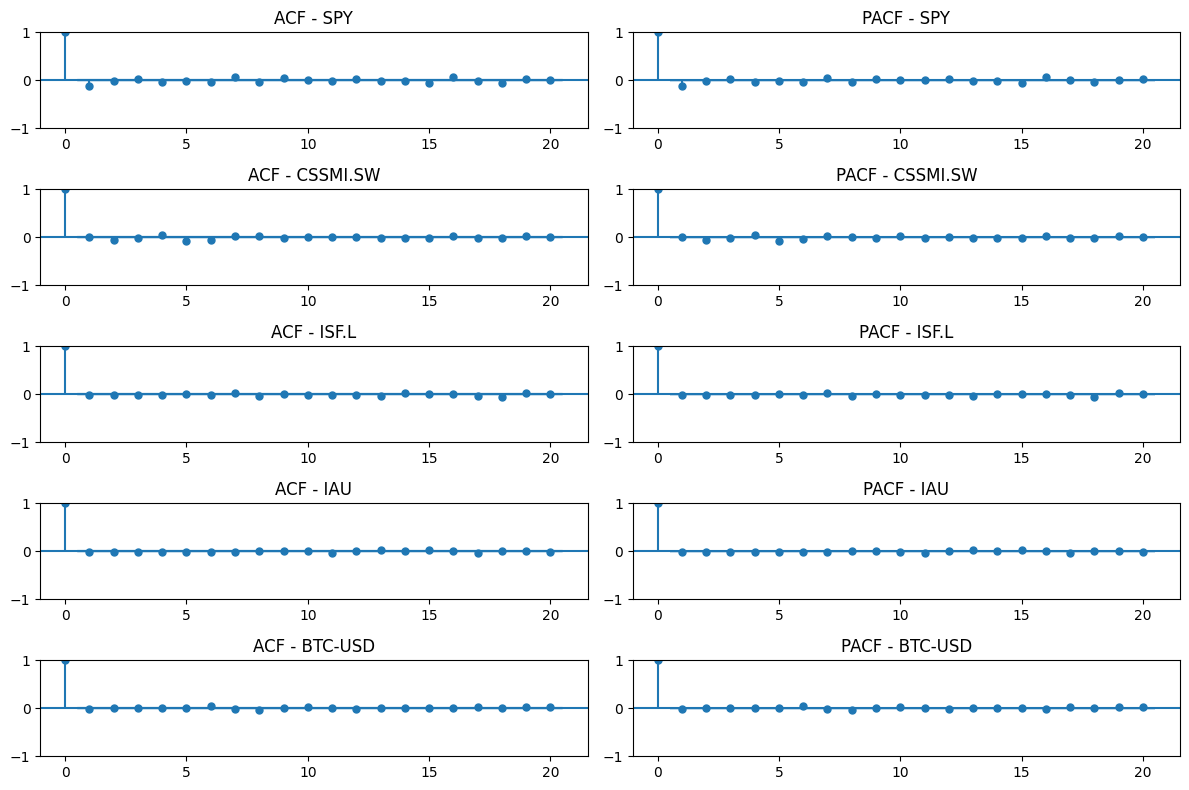

In [71]:
import statsmodels.api as sm

# For each asset, plot ACF and PACF
fig, ax = plt.subplots(len(log_returns.columns), 2, figsize=(12, 8))

for i, asset in enumerate(log_returns.columns):
    sm.graphics.tsa.plot_acf(log_returns[asset], lags=20, ax=ax[i][0])
    sm.graphics.tsa.plot_pacf(log_returns[asset], lags=20, ax=ax[i][1])
    ax[i][0].set_title(f'ACF - {asset}')
    ax[i][1].set_title(f'PACF - {asset}')

plt.tight_layout()
plt.show()


Shapiro-Wilk test for SPY: p-value = 0.00000000
Shapiro-Wilk test for CSSMI.SW: p-value = 0.00000000
Shapiro-Wilk test for ISF.L: p-value = 0.00000000
Shapiro-Wilk test for IAU: p-value = 0.00000000
Shapiro-Wilk test for BTC-USD: p-value = 0.00000000


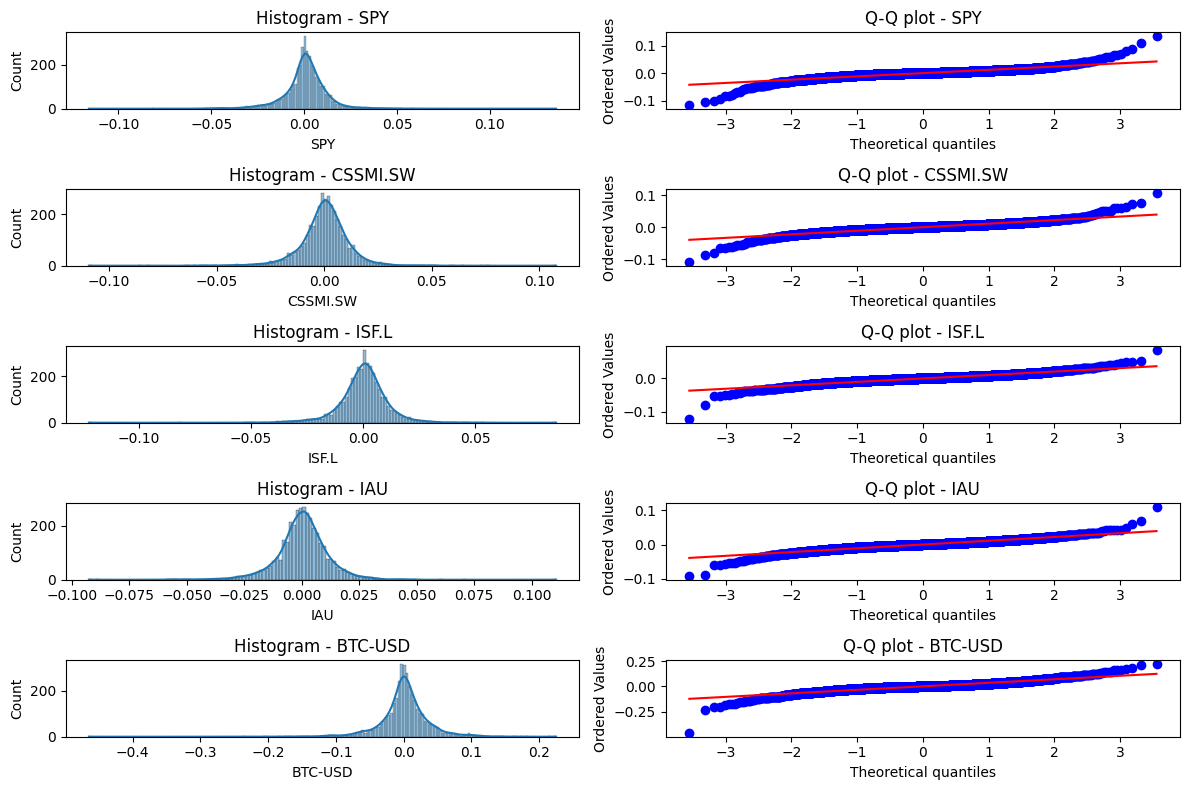

In [73]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Shapiro-Wilk Test for normality
for asset in log_returns.columns:
    stat, p_value = stats.shapiro(log_returns[asset])
    print(f"Shapiro-Wilk test for {asset}: p-value = {p_value:.8f}")

fig, ax = plt.subplots(len(log_returns.columns), 2, figsize=(12, 8))

for i, asset in enumerate(log_returns.columns):
    sns.histplot(log_returns[asset], kde=True, ax=ax[i][0])
    ax[i][0].set_title(f'Histogram - {asset}')
    stats.probplot(log_returns[asset], dist="norm", plot=ax[i][1])
    ax[i][1].set_title(f'Q-Q plot - {asset}')

plt.tight_layout()
plt.show()



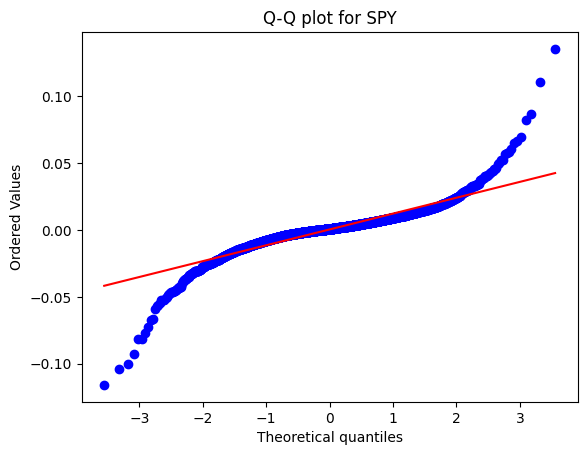

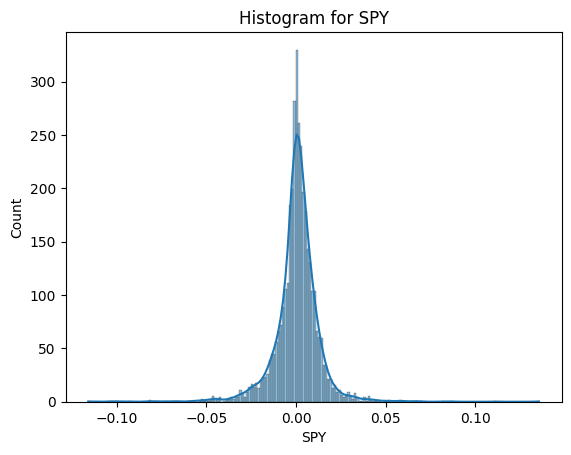

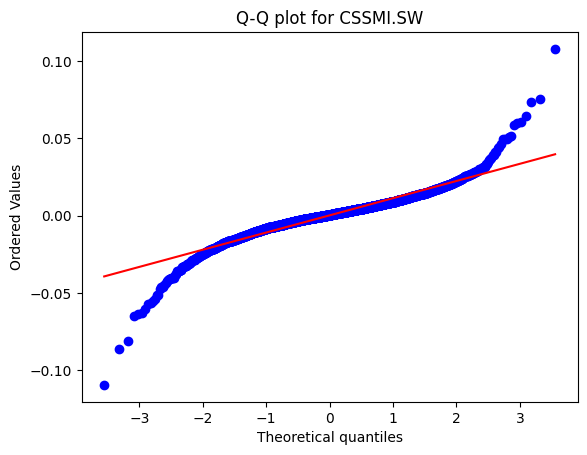

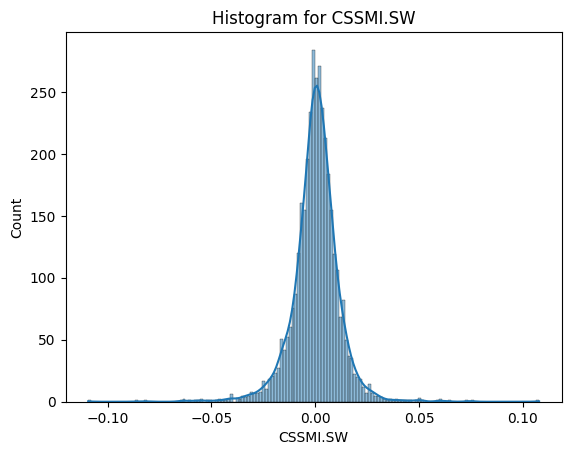

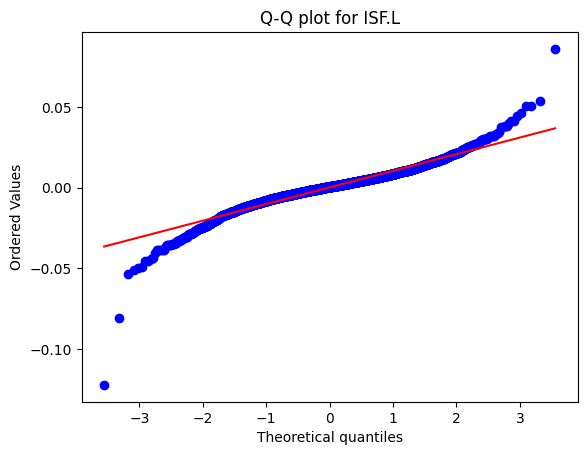

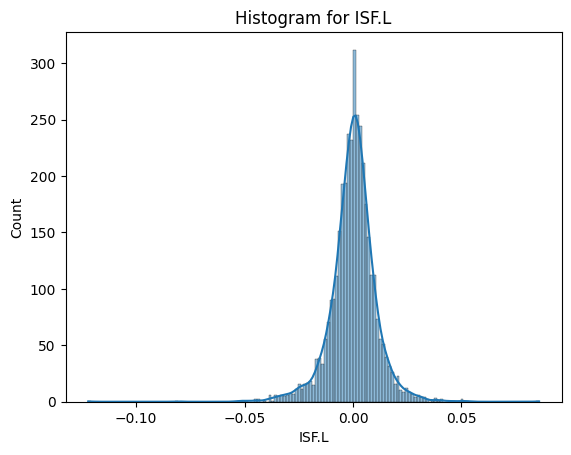

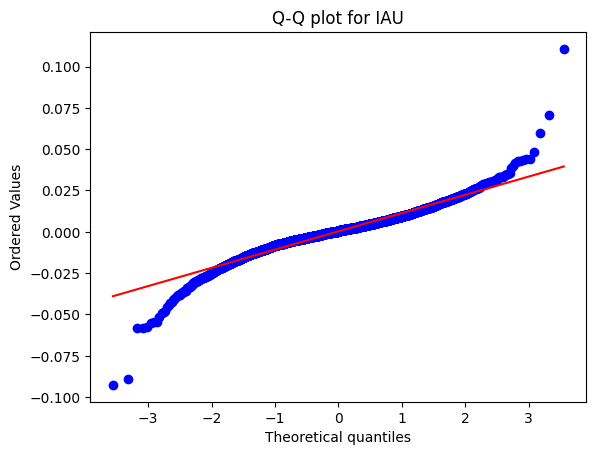

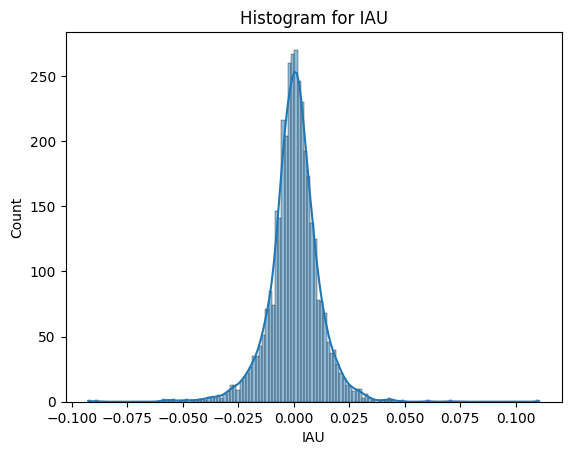

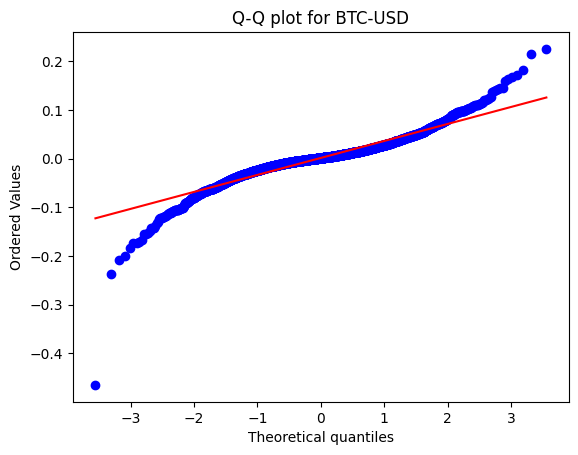

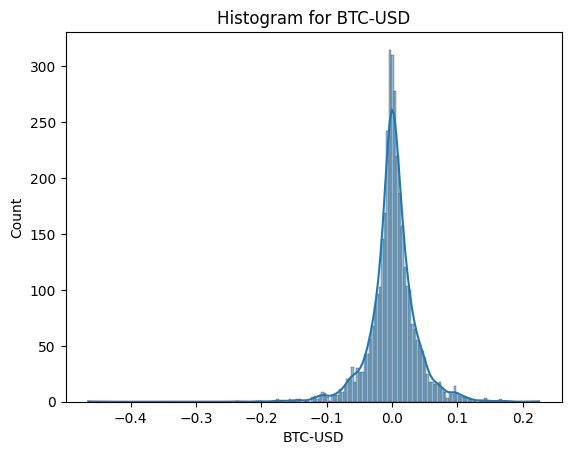

In [74]:
# For more visibility, we re-plot

for asset in log_returns.columns:
  # Q-Q Plot

  stats.probplot(log_returns[asset], dist="norm", plot=plt)
  plt.title(f"Q-Q plot for {asset}")
  plt.show()

  # Histogram and Kernel Density Estimate (KDE)
  sns.histplot(log_returns[asset], kde=True)
  plt.title(f"Histogram for {asset}")
  plt.show()


In [75]:
from statsmodels.tsa.stattools import adfuller

for asset in log_returns.columns:
    result = adfuller(log_returns[asset])
    print(f"ADF Test for {asset}: p-value = {result[1]}")

ADF Test for SPY: p-value = 2.152115482499471e-27
ADF Test for CSSMI.SW: p-value = 0.0
ADF Test for ISF.L: p-value = 0.0
ADF Test for IAU: p-value = 0.0
ADF Test for BTC-USD: p-value = 2.1688288737753558e-30


In [77]:
from statsmodels.stats.stattools import durbin_watson

for asset in log_returns.columns:
    dw_stat = durbin_watson(log_returns[asset])
    print(f"Durbin-Watson Test for {asset}: DW Statistic = {dw_stat}")

Durbin-Watson Test for SPY: DW Statistic = 2.2391452439483523
Durbin-Watson Test for CSSMI.SW: DW Statistic = 1.9929985541023658
Durbin-Watson Test for ISF.L: DW Statistic = 2.016210104639465
Durbin-Watson Test for IAU: DW Statistic = 2.01052276985319
Durbin-Watson Test for BTC-USD: DW Statistic = 2.0391471556634255
